In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install catboost
!pip3 install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.2 MB/s eta 0:00:00


In [ ]:
import unicodedata
from pathlib import Path

import catboost as cb
import optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler
import datetime

In [ ]:

exp_name = 'exp00018'

outputs_path = f'/content/drive/MyDrive/Colab Notebooks/signate2023/{exp_name}/'

submission_dir = outputs_path + 'submissions/'
submission_path = submission_dir + f'submission_{exp_name}.csv'

model_dir = outputs_path + f'signate-models/'

for dir in [model_dir]:
    os.makedirs(dir, exist_ok=True)

In [ ]:
INPUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/signate2023/")

In [ ]:
train_df = pd.read_csv(INPUT_DIR / "train.csv")
test_df = pd.read_csv(INPUT_DIR / "test.csv")
sub_df = pd.read_csv(INPUT_DIR / "submit_sample.csv", names=["id", "price"])

In [ ]:
import unicodedata

# Define a function to normalize manufacturer names
def normalize_manufacturer_name(name):
    # Convert full-width characters to half-width
    name = unicodedata.normalize('NFKC', name)
    # Convert to lowercase
    name = name.lower()
    # Remove non-ASCII characters
    name = ''.join(char for char in name if ord(char) < 128)
    return name


class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # cylinderから数値を取り出す
        X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")

        # sizeの表記揺れを修正
        X["size"] = X["size"].str.replace("ー", "-").astype(str)
        X["size"] = X["size"].str.replace("−", "-").astype(str)

        # Apply the function to the 'manufacturer' column
        X['manufacturer'] = X['manufacturer'].apply(normalize_manufacturer_name)

        X.loc[X['odometer'] == -1, 'odometer'] = np.nan


        # Define a dictionary for manufacturer name mapping with special characters
        manufacturer_name_mapping = {
            'nisan': 'nissan',
            'toyot': 'toyota',
            'nisѕan': 'nissan',
            'subαru': 'subaru',
            'subru': 'subaru',
            'sαturn': 'saturn',
            'lexu':'lexus',
            'аcura': 'acura',
            'vоlkswagen': 'volkswagen',
            'vlkswagen': 'volkswagen',
            'lexuѕ': 'lexus',
            'ᴄhrysler': 'chrysler',
            'sturn': 'saturn'
        }

        # Replace the manufacturer names using the mapping
        X['manufacturer'] = X['manufacturer'].replace(manufacturer_name_mapping)


        # yearが3000年以降のものはおかしいので2000年に置換
        err_idx = X.query("year >= 3000").index
        X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

        # 走行距離 / 製造年
        X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

        return X


class RankTransformer(TransformerMixin, BaseEstimator):
    """keyの中でvalueが何番目のものか"""

    def __init__(self, key: str, value: str):
        self.key = key
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new[self.key] = X_new.groupby(self.key)[self.value].rank(method="dense")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return [self.key]


class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        #X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols


class CountTransformer(TransformerMixin, BaseEstimator):
    """CountEncoder"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.ce = CountEncoder(cols=X.columns.tolist(), handle_unknown=0)
        self.ce.fit(X)
        return self

    def transform(self, X):
        return self.ce.transform(X)

    def get_feature_names_out(self, input_features=None):
        return input_features


class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [ ]:
numeric_cols = ["year", "odometer", "odometer_per_year"]
categorical_cols = [
    'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "ct",
            CountTransformer(),
            categorical_cols
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            [
                'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
            ],
        ),
        *[
             (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean", "std"}), [key] + ["odometer"])
             for key in [
                 "manufacturer",
                 "cylinders",
                 "condition",
                 "fuel",
                 "drive",
                 "size",
                 "type",
             ]
         ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


[ColumnTransformer] .......... (1 of 10) Processing ori, total=   0.0s
[ColumnTransformer] ........... (2 of 10) Processing ct, total=   1.6s
[ColumnTransformer] .......... (3 of 10) Processing tgt, total=   0.4s
[ColumnTransformer]  (4 of 10) Processing agg_manufacturer, total=   0.1s
[ColumnTransformer]  (5 of 10) Processing agg_cylinders, total=   0.1s
[ColumnTransformer]  (6 of 10) Processing agg_condition, total=   0.1s
[ColumnTransformer] ..... (7 of 10) Processing agg_fuel, total=   0.1s
[ColumnTransformer] .... (8 of 10) Processing agg_drive, total=   0.0s
[ColumnTransformer] ..... (9 of 10) Processing agg_size, total=   0.0s
[ColumnTransformer] .... (10 of 10) Processing agg_type, total=   0.1s


In [ ]:
state_dic = {}

# データ数的に、重複は気にせず上書きしていっても大した時間にはならない
for i in train_feat_df.index:
    # ただし、欠損値で上書きされると困るので、そこだけケア
    if pd.isna(train_feat_df.at[i, 'ori__state'])==False:
        state_dic[train_feat_df.at[i, 'ori__region']] = train_feat_df.at[i, 'ori__state']

train_feat_df.loc[pd.isna(train_feat_df['ori__state']).index, 'ori__state'] = train_feat_df.loc[pd.isna(train_feat_df['ori__state']).index, 'ori__region'].map(state_dic)
test_feat_df.loc[pd.isna(test_feat_df['ori__state']).index, 'ori__state'] = test_feat_df.loc[pd.isna(test_feat_df['ori__state']).index, 'ori__region'].map(state_dic)

In [ ]:
pd.set_option('display.max_columns', None)
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,tgt__region,tgt__cylinders,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excellent,gas,clean,manual,rwd,mid-size,convertible,orange,tn,229,11504,3044,15219,23546,22365,6156,4834,9411,418,144,3304,14718.312131,14451.208521,13954.496464,14633.535038,12296.169311,13262.602450,12150.050543,15985.487131,12192.374008,13917.834568,11456.355949,13537.107497,54592.395342,99532.887011,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,65581.670291,115464.542489,54324.383605,102805.990385
1,2013.0,172038.0,17203.800781,state college,8.0,toyota,fair,gas,clean,automatic,rwd,full-size,sedan,silver,pa,12,5727,1784,2404,23546,22365,20497,4834,14636,9259,4300,983,8971.284315,16300.143568,9236.582715,7244.253681,12214.504336,13225.978879,13910.841120,15681.495329,15310.042973,9956.111283,11320.869501,13366.765745,63883.018881,150274.987542,62494.750709,115307.855683,61282.605340,154892.925693,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,57689.686211,115614.553873
2,1998.0,152492.0,6099.680176,wichita,6.0,ford,good,gas,clean,automatic,fwd,full-size,SUV,silver,ks,233,11504,6943,6009,23546,22365,20497,14602,14636,7311,4300,252,11842.875444,14443.224620,14715.468636,10971.909137,12225.230115,13247.724494,13930.228325,9767.198243,15394.279395,13790.471227,11280.831957,11528.957562,63040.922707,117902.164170,62481.637708,117712.542875,62670.409248,128844.689852,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,70098.520676,123372.880094
3,2014.0,104118.0,11568.666992,albany,4.0,ford,excellent,gas,clean,manual,fwd,mid-size,SUV,blue,ny,504,10071,6943,15219,23546,22365,6156,14602,9411,7311,3765,1841,16048.366610,10540.713416,14715.468636,14665.686916,12225.230115,13247.724494,12061.623432,9767.198243,12115.821933,13790.471227,13803.616190,14511.524765,63040.922707,117902.164170,65948.060685,117652.023240,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,70098.520676,123372.880094
4,2005.0,144554.0,8030.777832,redding,6.0,ford,excellent,gas,clean,manual,fwd,mid-size,sedan,red,ca,153,11504,6943,15219,23546,22365,6156,14602,9411,9259,1419,2702,10179.798890,14503.401593,14789.592342,14680.774136,12240.361505,13276.786034,12117.939502,9767.130897,12229.251520,9860.993469,11881.618402,13691.209249,63040.922707,117902.164170,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,57689.686211,115614.553873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,2008.0,26660.0,1777.333374,williamsport,6.0,ford,good,gas,clean,automatic,rwd,compact,truck,black,pa,49,11504,6943,6009,23546,22365,20497,4834,3352,3837,10143,983,14555.197953,14503.401593,14789.592342,11003.298800,12240.361505,13276.786034,13943.426349,15947.532658,8825.977878,20355.841082,14828.422588,13300.181445,63040.922707,1

In [ ]:
# Create a discretizer
#discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
#train_data_encoded['odometer_binned'] = discretizer.fit_transform(train_data_encoded[['ori__odometer']])
#test_data_encoded['odometer_binned'] = discretizer.transform(test_data_encoded[['ori__odometer']])

In [ ]:
# Create a robust scaler
scaler = RobustScaler()
train_feat_df['odometer_scaled'] = scaler.fit_transform(train_feat_df[['ori__odometer']])
test_feat_df['odometer_scaled'] = scaler.transform(test_feat_df[['ori__odometer']])

In [ ]:
# Apply log transformation to 'odometer'
train_feat_df['odometer_log'] = np.log1p(train_feat_df['ori__odometer'])
test_feat_df['odometer_log'] = np.log1p(test_feat_df['ori__odometer'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Create a new feature 'car_age'
current_year = datetime.datetime.now().year
train_feat_df['car_age'] = current_year - train_feat_df['ori__year']
test_feat_df['car_age'] = current_year - test_feat_df['ori__year']

In [ ]:
# odometer_scaledとcar_ageの交互作用を新たな特徴量として作成します
train_feat_df['odometer_age_interaction'] = train_feat_df['ori__odometer'] * train_feat_df['car_age']
test_feat_df['odometer_age_interaction'] = test_feat_df['ori__odometer'] * test_feat_df['car_age']

In [ ]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# SimpleImputerをインスタンス化（ここでは欠損値を中央値で補完）
imputer = SimpleImputer(strategy='median')

# 補完を行いたい特徴量を選択
features = train_feat_df[['ori__odometer', 'car_age']].copy()

# 欠損値補完
features_imputed = imputer.fit_transform(features)

# KMeansクラスタリングを設定
kmeans = KMeans(n_clusters=10, random_state=0)

# 補完されたデータに基づいてクラスタリング
train_feat_df['odometer_age_cluster'] = kmeans.fit_predict(features_imputed)

# テストデータについても同様に処理
features_test = test_feat_df[['ori__odometer', 'car_age']].copy()
features_test_imputed = imputer.transform(features_test)
test_feat_df['odometer_age_cluster'] = kmeans.predict(features_test_imputed)

# 元のodometer_scaledの欠損値を復元
train_feat_df['ori__odometer'] = features['ori__odometer']
test_feat_df['ori__odometer'] = features_test['ori__odometer']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,tgt__region,tgt__cylinders,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,odometer_scaled,odometer_log,car_age,odometer_age_interaction,odometer_age_cluster
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excellent,gas,clean,manual,rwd,mid-size,convertible,orange,tn,229,11504,3044,15219,23546,22365,6156,4834,9411,418,144,3304,14718.312131,14451.208521,13954.496464,14633.535038,12296.169311,13262.602450,12150.050543,15985.487131,12192.374008,13917.834568,11456.355949,13537.107497,54592.395342,99532.887011,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,65581.670291,115464.542489,54324.383605,102805.990385,0.043134,11.653982,74.0,8520952.0,0
1,2013.0,172038.0,17203.800781,state college,8.0,toyota,fair,gas,clean,automatic,rwd,full-size,sedan,silver,pa,12,5727,1784,2404,23546,22365,20497,4834,14636,9259,4300,983,8971.284315,16300.143568,9236.582715,7244.253681,12214.504336,13225.978879,13910.841120,15681.495329,15310.042973,9956.111283,11320.869501,13366.765745,63883.018881,150274.987542,62494.750709,115307.855683,61282.605340,154892.925693,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,57689.686211,115614.553873,0.834587,12.055476,10.0,1720380.0,5
2,1998.0,152492.0,6099.680176,wichita,6.0,ford,good,gas,clean,automatic,fwd,full-size,SUV,silver,ks,233,11504,6943,6009,23546,22365,20497,14602,14636,7311,4300,252,11842.875444,14443.224620,14715.468636,10971.909137,12225.230115,13247.724494,13930.228325,9767.198243,15394.279395,13790.471227,11280.831957,11528.957562,63040.922707,117902.164170,62481.637708,117712.542875,62670.409248,128844.689852,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,70098.520676,123372.880094,0.562663,11.934874,25.0,3812300.0,3
3,2014.0,104118.0,11568.666992,albany,4.0,ford,excellent,gas,clean,manual,fwd,mid-size,SUV,blue,ny,504,10071,6943,15219,23546,22365,6156,14602,9411,7311,3765,1841,16048.366610,10540.713416,14715.468636,14665.686916,12225.230115,13247.724494,12061.623432,9767.198243,12115.821933,13790.471227,13803.616190,14511.524765,63040.922707,117902.164170,65948.060685,117652.023240,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,70098.520676,123372.880094,-0.110315,11.553289,9.0,937062.0,8
4,2005.0,144554.0,8030.777832,redding,6.0,ford,excellent,gas,clean,manual,fwd,mid-size,sedan,red,ca,153,11504,6943,15219,23546,22365,6156,14602,9411,9259,1419,2702,10179.798890,14503.401593,14789.592342,14680.774136,12240.361505,13276.786034,12117.939502,9767.130897,12229.251520,9860.993469,11881.618402,13691.209249,63040.922707,117902.164170,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,57689.686211,115614.553873,0.452230,11.881415,18.0,2601972.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,2008.0,26660.0,1777.333374,williamsport,6.0,ford,g

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# 3. Binning features
# Binning 'odometer_scaled' into 10 bins
train_feat_df['odometer_scaled_bin'] = pd.cut(train_feat_df['ori__odometer'], bins=10, labels=False)
test_feat_df['odometer_scaled_bin'] = pd.cut(test_feat_df['ori__odometer'], bins=10, labels=False)

# Binning 'car_age' into 10 bins
train_feat_df['car_age_bin'] = pd.cut(train_feat_df['car_age'], bins=10, labels=False)
test_feat_df['car_age_bin'] = pd.cut(test_feat_df['car_age'], bins=10, labels=False)

# One-hot encoding the binned features
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# 'odometer_scaled_bin'
ohe.fit(train_feat_df[['odometer_scaled_bin']])
train_data_ohe = pd.DataFrame(ohe.transform(train_feat_df[['odometer_scaled_bin']]), columns=[f"odometer_scaled_bin_{c}" for c in ohe.categories_[0]])
test_data_ohe = pd.DataFrame(ohe.transform(test_feat_df[['odometer_scaled_bin']]), columns=[f"odometer_scaled_bin_{c}" for c in ohe.categories_[0]])
train_feat_df = pd.concat([train_feat_df, train_data_ohe], axis=1)
test_feat_df = pd.concat([test_feat_df, test_data_ohe], axis=1)
train_feat_df.drop('odometer_scaled_bin', axis=1, inplace=True)
test_feat_df.drop('odometer_scaled_bin', axis=1, inplace=True)

# 'car_age_bin'
ohe.fit(train_feat_df[['car_age_bin']])
train_data_ohe = pd.DataFrame(ohe.transform(train_feat_df[['car_age_bin']]), columns=[f"car_age_bin_{c}" for c in ohe.categories_[0]])
test_data_ohe = pd.DataFrame(ohe.transform(test_feat_df[['car_age_bin']]), columns=[f"car_age_bin_{c}" for c in ohe.categories_[0]])
train_feat_df = pd.concat([train_feat_df, train_data_ohe], axis=1)
test_feat_df = pd.concat([test_feat_df, test_data_ohe], axis=1)
train_feat_df.drop('car_age_bin', axis=1, inplace=True)
test_feat_df.drop('car_age_bin', axis=1, inplace=True)
train_feat_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,tgt__region,tgt__cylinders,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,odometer_scaled,odometer_log,car_age,odometer_age_interaction,odometer_age_cluster,odometer_scaled_bin_0.0,odometer_scaled_bin_1.0,odometer_scaled_bin_4.0,odometer_scaled_bin_5.0,odometer_scaled_bin_9.0,odometer_scaled_bin_nan,car_age_bin_0,car_age_bin_9
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excellent,gas,clean,manual,rwd,mid-size,convertible,orange,tn,229,11504,3044,15219,23546,22365,6156,4834,9411,418,144,3304,14718.312131,14451.208521,13954.496464,14633.535038,12296.169311,13262.602450,12150.050543,15985.487131,12192.374008,13917.834568,11456.355949,13537.107497,54592.395342,99532.887011,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,65581.670291,115464.542489,54324.383605,102805.990385,0.043134,11.653982,74.0,8520952.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2013.0,172038.0,17203.800781,state college,8.0,toyota,fair,gas,clean,automatic,rwd,full-size,sedan,silver,pa,12,5727,1784,2404,23546,22365,20497,4834,14636,9259,4300,983,8971.284315,16300.143568,9236.582715,7244.253681,12214.504336,13225.978879,13910.841120,15681.495329,15310.042973,9956.111283,11320.869501,13366.765745,63883.018881,150274.987542,62494.750709,115307.855683,61282.605340,154892.925693,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,57689.686211,115614.553873,0.834587,12.055476,10.0,1720380.0,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1998.0,152492.0,6099.680176,wichita,6.0,ford,good,gas,clean,automatic,fwd,full-size,SUV,silver,ks,233,11504,6943,6009,23546,22365,20497,14602,14636,7311,4300,252,11842.875444,14443.224620,14715.468636,10971.909137,12225.230115,13247.724494,13930.228325,9767.198243,15394.279395,13790.471227,11280.831957,11528.957562,63040.922707,117902.164170,62481.637708,117712.542875,62670.409248,128844.689852,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,70098.520676,123372.880094,0.562663,11.934874,25.0,3812300.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2014.0,104118.0,11568.666992,albany,4.0,ford,excellent,gas,clean,manual,fwd,mid-size,SUV,blue,ny,504,10071,6943,15219,23546,22365,6156,14602,9411,7311,3765,1841,16048.366610,10540.713416,14715.468636,14665.686916,12225.230115,13247.724494,12061.623432,9767.198243,12115.821933,13790.471227,13803.616190,14511.524765,63040.922707,117902.164170,65948.060685,117652.023240,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,70098.520676,123372.880094,-0.110315,11.553289,9.0,937062.0,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2005.0,144554.0,8030.777832,redding,6.0,ford,excellent,gas,clean,manual,fwd,mid-size,sedan,red,ca,153,11504,6943,15219,23546,22365,6156,14602,9411,9259,1419,2702,10179.798890,14503.401593,14789.592342,14680.774136,12240.361505,13276.786034,12117.939502,9767.130897,12229.251520,9860.993469,11881.618402,13691.209249,63040.922707,117902.164170,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,57689.686211,115614.553873,0.452230,11.881415,18.0,2601

In [ ]:
# 1. odometerに対する他の特徴量の比率
# 年ごとの平均odometer値を計算
mean_odometer_per_year = train_feat_df.groupby('ori__year')['ori__odometer'].transform('mean')
# 年ごとのodometerの比率を計算
train_feat_df['odometer_ratio_year'] = train_feat_df['ori__odometer'] / mean_odometer_per_year
# 同様にテストデータセットに対しても行う
mean_odometer_per_year_test = test_feat_df.groupby('ori__year')['ori__odometer'].transform('mean')
test_feat_df['odometer_ratio_year'] = test_feat_df['ori__odometer'] / mean_odometer_per_year_test

# 2. 'odometer'の時間経過による変化
train_feat_df['odometer_per_year'] = train_feat_df['ori__odometer'] / train_feat_df['car_age']
test_feat_df['odometer_per_year'] = test_feat_df['ori__odometer'] / test_feat_df['car_age']

# 3. 'odometer'に関する統計量
# manufacturerごとのodometerの統計量を計算
train_feat_df['mean_odometer_per_manufacturer'] = train_feat_df.groupby('tgt__manufacturer')['ori__odometer'].transform('mean')
train_feat_df['std_odometer_per_manufacturer'] = train_feat_df.groupby('tgt__manufacturer')['ori__odometer'].transform('std')
# 同様にテストデータセットに対しても行う
test_feat_df['mean_odometer_per_manufacturer'] = test_feat_df.groupby('tgt__manufacturer')['ori__odometer'].transform('mean')
test_feat_df['std_odometer_per_manufacturer'] = test_feat_df.groupby('tgt__manufacturer')['ori__odometer'].transform('std')

# 4. 'odometer'のランク
train_feat_df['odometer_rank_region'] = train_feat_df.groupby('ori__region')['ori__odometer'].rank()
test_feat_df['odometer_rank_region'] = test_feat_df.groupby('ori__region')['ori__odometer'].rank()

# 5. 'odometer'のビン化
train_feat_df['odometer_bin_100k'] = pd.cut(train_feat_df['ori__odometer'], bins=[0, 100000, 200000, 300000, np.inf], labels=False)
test_feat_df['odometer_bin_100k'] = pd.cut(test_feat_df['ori__odometer'], bins=[0, 100000, 200000, 300000, np.inf], labels=False)

# 6. 'odometer'の他の数学的変換
train_feat_df['odometer_sqrt'] = np.sqrt(train_feat_df['ori__odometer'])
test_feat_df['odometer_sqrt'] = np.sqrt(test_feat_df['ori__odometer'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
test_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,tgt__region,tgt__cylinders,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,odometer_scaled,odometer_log,car_age,odometer_age_interaction,odometer_age_cluster,odometer_scaled_bin_0.0,odometer_scaled_bin_1.0,odometer_scaled_bin_4.0,odometer_scaled_bin_5.0,odometer_scaled_bin_9.0,odometer_scaled_bin_nan,car_age_bin_0,car_age_bin_9,odometer_ratio_year,odometer_per_year,mean_odometer_per_manufacturer,std_odometer_per_manufacturer,odometer_rank_region,odometer_bin_100k,odometer_sqrt
0,2015.0,92553.0,11569.125000,western slope,4.0,chevrolet,excellent,gas,clean,automatic,fwd,full-size,SUV,red,co,138,10071,3807,15219,23546,22365,20497,14602,14636,7311,1419,3304,12364.873861,10553.046813,14994.074493,14662.314415,12251.735036,13276.956914,13944.41638,9810.374435,15394.953240,13821.072917,11812.789531,13726.870953,73406.762289,106672.400956,65948.060685,117652.023240,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,70098.520676,123372.880094,-0.271207,11.435548,8.0,740424.0,8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.963558,11569.125000,106933.703125,57524.881757,30.0,0.0,304.225250
1,2013.0,134385.0,13438.500000,roseburg,4.0,nissan,like new,gas,salvage,automatic,fwd,mid-size,sedan,black,or,21,10071,1003,3810,23546,985,20497,14602,9411,9259,10143,577,11298.195115,10553.046813,10005.818945,16510.276020,12251.735036,12352.004779,13944.41638,9810.374435,12158.496396,9939.803859,14798.576380,13692.255137,58456.216704,122262.582915,65948.060685,117652.023240,57656.409651,96607.548515,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,57689.686211,115614.553873,0.310759,11.808472,10.0,1343850.0,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.245104,13438.500000,118536.914062,56015.482392,11.0,1.0,366.585602
2,2011.0,102489.0,8540.750000,akron / canton,4.0,volkswagen,good,gas,clean,automatic,fwd,full-size,sedan,black,oh,102,10071,773,6009,23546,22365,20497,14602,14636,9259,10143,849,12559.078133,10553.046813,8002.268829,11022.863826,12251.735036,13276.956914,13944.41638,9810.374435,15394.953240,9939.803859,14798.576380,11788.498453,62583.242934,111367.834204,65948.060685,117652.023240,62670.409248,128844.689852,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,57689.686211,115614.553873,-0.132978,11.537520,12.0,1229868.0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901052,8540.750000,112607.312500,52868.812265,50.0,1.0,320.139038
3,2016.0,64310.0,9187.142578,denver,6.0,jeep,excellent,diesel,clean,automatic,4wd,mid-size,SUV,red,co,246,11504,1297,15219,2639,22365,20497,8096,9411,7311,1419,705,12608.590272,14480.395637,15060.984391,14662.314415,24795.796686,13276.956914,13944.41638,18646.321078,12158.496396,13821.072917,11812.789531,12496.747029,55275.381309,124203.237129,62481.637708,117712.542875,62813.625983,111814.618855,86518.096671,111824.779648,69736.633841,121182.685864,65581.670291,115464.542489,70098.520676,123372.880094,-0.664123,11.071486,7.0,450170.0,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.726973,9187.142578,122659.140625,57290.933229,39.0,0.0,253.594162
4,1999.0,180839.0,7534.958496,hickory / lenoir,8.0,honda,excellent,gas,rebuilt,automatic,

In [ ]:


# List of categorical columns to apply label encoding
label_cols = ['ori__region']
onehot_cols = ['ori__manufacturer', 'ori__condition', 'ori__fuel', 'ori__title_status',
               'ori__transmission', 'ori__drive', 'ori__size', 'ori__type', 'ori__paint_color', 'ori__state']

# Create a copy of the dataframes
train_data_encoded = train_feat_df.copy()
test_data_encoded = test_feat_df.copy()

# Instantiate the LabelEncoder and OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

# Apply label encoding
for col in label_cols:
    # Fit the encoder on the training data
    le.fit(train_data_encoded[col])

    # Transform the data
    train_data_encoded[col] = le.transform(train_data_encoded[col])
    test_data_encoded[col] = le.transform(test_data_encoded[col])

# Apply one-hot encoding
for col in onehot_cols:
    # Fit the encoder on the training data
    ohe.fit(train_data_encoded[[col]])

    # Transform the data
    train_data_ohe = pd.DataFrame(ohe.transform(train_data_encoded[[col]]), columns=[f"{col}_{c}" for c in ohe.categories_[0]])
    test_data_ohe = pd.DataFrame(ohe.transform(test_data_encoded[[col]]), columns=[f"{col}_{c}" for c in ohe.categories_[0]])

    # Drop the original column
    train_data_encoded.drop(col, axis=1, inplace=True)
    test_data_encoded.drop(col, axis=1, inplace=True)

    # Concatenate the one-hot encoded columns
    train_data_encoded = pd.concat([train_data_encoded, train_data_ohe], axis=1)
    test_data_encoded = pd.concat([test_data_encoded, test_data_ohe], axis=1)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

In [ ]:
train_feat_df = train_data_encoded
test_feat_df = test_data_encoded

In [ ]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

n_fold = 5
feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()
cv = get_cv(train_feat_df, n_fold=5)

In [ ]:
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,tgt__region,tgt__cylinders,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,odometer_scaled,odometer_log,car_age,odometer_age_interaction,odometer_age_cluster,odometer_scaled_bin_0.0,odometer_scaled_bin_1.0,odometer_scaled_bin_4.0,odometer_scaled_bin_5.0,odometer_scaled_bin_9.0,odometer_scaled_bin_nan,car_age_bin_0,car_age_bin_9,odometer_ratio_year,odometer_per_year,mean_odometer_per_manufacturer,std_odometer_per_manufacturer,odometer_rank_region,odometer_bin_100k,odometer_sqrt,ori__manufacturer_acura,ori__manufacturer_alfa-romeo,ori__manufacturer_aston-martin,ori__manufacturer_audi,ori__manufacturer_bmw,ori__manufacturer_buick,ori__manufacturer_cadillac,ori__manufacturer_chevrolet,ori__manufacturer_chrysler,ori__manufacturer_cura,ori__manufacturer_dodge,ori__manufacturer_fiat,ori__manufacturer_ford,ori__manufacturer_gmc,ori__manufacturer_honda,ori__manufacturer_hrysler,ori__manufacturer_hyundai,ori__manufacturer_infiniti,ori__manufacturer_jaguar,ori__manufacturer_jeep,ori__manufacturer_kia,ori__manufacturer_land rover,ori__manufacturer_lexus,ori__manufacturer_lincoln,ori__manufacturer_mazda,ori__manufacturer_mercedes-benz,ori__manufacturer_mercury,ori__manufacturer_mini,ori__manufacturer_mitsubishi,ori__manufacturer_nissan,ori__manufacturer_pontiac,ori__manufacturer_porsche,ori__manufacturer_ram,ori__manufacturer_rover,ori__manufacturer_saturn,ori__manufacturer_subaru,ori__manufacturer_toyota,ori__manufacturer_volkswagen,ori__manufacturer_volvo,ori__condition_excellent,ori__condition_fair,ori__condition_good,ori__condition_like new,ori__condition_new,ori__condition_salvage,ori__fuel_diesel,ori__fuel_electric,ori__fuel_gas,ori__fuel_hybrid,ori__fuel_other,ori__fuel_nan,ori__title_status_clean,ori__title_status_lien,ori__title_status_missing,ori__title_status_parts only,ori__title_status_rebuilt,ori__title_status_salvage,ori__title_status_nan,ori__transmission_automatic,ori__transmission_manual,ori__transmission_other,ori__drive_4wd,ori__drive_fwd,ori__drive_rwd,ori__size_compact,ori__size_full-size,ori__size_mid-size,ori__size_sub-compact,ori__type_SUV,ori__type_bus,ori__type_convertible,ori__type_coupe,ori__type_hatchback,ori__type_mini-van,ori__type_offroad,ori__type_other,ori__type_pickup,ori__type_sedan,ori__type_truck,ori__type_van,ori__type_wagon,ori__type_nan,ori__paint_color_black,ori__paint_color_blue,ori__paint_color_brown,ori__paint_color_custom,ori__paint_color_green,ori__paint_color_grey,ori__paint_color_orange,ori__paint_color_purple,ori__paint_color_red,ori__paint_color_silver,ori__paint_color_white,ori__paint_color_yellow,ori__state_ak,ori__state_al,ori__state_ar,ori__state_az,ori__state_ca,ori__state_co,ori__state_ct,ori__state_dc,ori__state_de,ori__state_fl,ori__state_ga,ori__state_hi,ori__state_ia,ori__state_id,ori__state_il,ori__state_in,ori__state_ks,ori__state_ky,ori__state_la,ori__state_ma,ori__state_md,ori__state_me,ori__state_mi,ori__state_mn,ori__state_mo,ori__state_ms,ori__state_mt,ori__state_nc,ori__state_nd,ori__state_ne,ori__state_nh,ori__state_nj,ori__state_nm,ori__state_nv,ori__state_ny,ori__state_oh,ori__state_ok,ori__state_or,ori__state_pa,ori__state_ri,ori__state_sc,ori__state_sd,ori__state_tn,ori__state_tx,ori__state_ut,ori__state_va,ori__state_vt,ori__state_wa,ori__state_wi,ori__state_wv,ori__state_wy,ori__state_nan
0,1

In [ ]:
#train_feat_df = train_feat_df.fillna(train_feat_df.median())

In [ ]:
# infを最大値で置き換える
#train_feat_df = train_feat_df.replace([np.inf, -np.inf], np.nan)
#train_feat_df = train_feat_df.fillna(train_feat_df.max())

In [ ]:
# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(100, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
def tuning(train_feat_df, train_df, cv):
     def objective(trial):
         max_depth = trial.suggest_int("max_depth", 1, 10)
         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
         learning_rate = trial.suggest_float('learning_rate',0.03,0.1)
         n_estimators = trial.suggest_int('n_estimators', 100, 50000)

         params = {
             "objective": "mape",
             "n_estimators": n_estimators,
             "learning_rate": learning_rate,
             "max_depth": max_depth,
             "num_leaves": num_leaves,
             "colsample_bytree": colsample_bytree,
             "subsample": subsample,
             "metric": "mape",
             "importance_type": "gain",
             "random_state": 88,
         }

         score, _, _ = fit_lgbm(
             X=train_feat_df, y=train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
         )
         return score

     study = optuna.create_study(direction="minimize")
     study.optimize(objective, n_trials=100)
     print("Number of finished trials:", len(study.trials))
     print("Best trial:", study.best_trial.params)
     return study.best_trial.params

In [ ]:
Best trial: {'max_depth': 5, 'num_leaves': 29, 'colsample_bytree': 0.10925776123744423, 'subsample': 0.18867646482200673, 'learning_rate': 0.03157614522569169, 'n_estimators': 42630}
FINISHI: Whole Score: 0.4424

SyntaxError: ignored

In [ ]:
lgbm_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 42630,
    "learning_rate": 0.03157614522569169,
    "max_depth": 5,
    "num_leaves": 29,
    "colsample_bytree": 0.10925776123744423,
    "subsample":  0.18867646482200673,
    "importance_type": "gain",
    "random_state": 88,
}

# training
score, oof_lgb, models_lgb = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold1 - 0.4482


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold2 - 0.4386


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold3 - 0.4426


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold4 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold5 - 0.4394
FINISHI: Whole Score: 0.4429


In [ ]:
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,tgt__region,tgt__cylinders,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,ori__manufacturer_acura,ori__manufacturer_alfa-romeo,ori__manufacturer_aston-martin,ori__manufacturer_audi,ori__manufacturer_bmw,ori__manufacturer_buick,ori__manufacturer_cadillac,ori__manufacturer_chevrolet,ori__manufacturer_chrysler,ori__manufacturer_cura,ori__manufacturer_dodge,ori__manufacturer_fiat,ori__manufacturer_ford,ori__manufacturer_gmc,ori__manufacturer_honda,ori__manufacturer_hrysler,ori__manufacturer_hyundai,ori__manufacturer_infiniti,ori__manufacturer_jaguar,ori__manufacturer_jeep,ori__manufacturer_kia,ori__manufacturer_land rover,ori__manufacturer_lexus,ori__manufacturer_lincoln,ori__manufacturer_mazda,ori__manufacturer_mercedes-benz,ori__manufacturer_mercury,ori__manufacturer_mini,ori__manufacturer_mitsubishi,ori__manufacturer_nissan,ori__manufacturer_pontiac,ori__manufacturer_porsche,ori__manufacturer_ram,ori__manufacturer_rover,ori__manufacturer_saturn,ori__manufacturer_subaru,ori__manufacturer_toyota,ori__manufacturer_volkswagen,ori__manufacturer_volvo,ori__condition_excellent,ori__condition_fair,ori__condition_good,ori__condition_like new,ori__condition_new,ori__condition_salvage,ori__fuel_diesel,ori__fuel_electric,ori__fuel_gas,ori__fuel_hybrid,ori__fuel_other,ori__fuel_nan,ori__title_status_clean,ori__title_status_lien,ori__title_status_missing,ori__title_status_parts only,ori__title_status_rebuilt,ori__title_status_salvage,ori__title_status_nan,ori__transmission_automatic,ori__transmission_manual,ori__transmission_other,ori__drive_4wd,ori__drive_fwd,ori__drive_rwd,ori__size_compact,ori__size_full-size,ori__size_mid-size,ori__size_sub-compact,ori__type_SUV,ori__type_bus,ori__type_convertible,ori__type_coupe,ori__type_hatchback,ori__type_mini-van,ori__type_offroad,ori__type_other,ori__type_pickup,ori__type_sedan,ori__type_truck,ori__type_van,ori__type_wagon,ori__type_nan,ori__paint_color_black,ori__paint_color_blue,ori__paint_color_brown,ori__paint_color_custom,ori__paint_color_green,ori__paint_color_grey,ori__paint_color_orange,ori__paint_color_purple,ori__paint_color_red,ori__paint_color_silver,ori__paint_color_white,ori__paint_color_yellow,ori__state_ak,ori__state_al,ori__state_ar,ori__state_az,ori__state_ca,ori__state_co,ori__state_ct,ori__state_dc,ori__state_de,ori__state_fl,ori__state_ga,ori__state_hi,ori__state_ia,ori__state_id,ori__state_il,ori__state_in,ori__state_ks,ori__state_ky,ori__state_la,ori__state_ma,ori__state_md,ori__state_me,ori__state_mi,ori__state_mn,ori__state_mo,ori__state_ms,ori__state_mt,ori__state_nc,ori__state_nd,ori__state_ne,ori__state_nh,ori__state_nj,ori__state_nm,ori__state_nv,ori__state_ny,ori__state_oh,ori__state_ok,ori__state_or,ori__state_pa,ori__state_ri,ori__state_sc,ori__state_sd,ori__state_tn,ori__state_tx,ori__state_ut,ori__state_va,ori__state_vt,ori__state_wa,ori__state_wi,ori__state_wv,ori__state_wy,ori__state_nan,odometer_scaled,odometer_log,car_age
0,1949.0,115148.0,1556.054077,215,6.0,229,11504,3044,15219,23546,22365,6156,4834,9411,418,144,3304,14718.312131,14451.208521,13954.496464,14633.535038,12296.169311,13262.602450,12150.050543,15985.487131,12192.374008,13917.834568,11456.355949,13537.107497,54592.395342,99532.887011,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,62270.60852

In [ ]:
n_fold = 5
#lgbm_params = {
#    "objective": "mape",
#    "metrics": "mape",
#    "n_estimators": 10000,
#    "learning_rate": 0.01,
#    "max_depth": 5,
#    "num_leaves": 32,
#    "colsample_bytree": 0.446,
#    "subsample": 0.339,
#    "importance_type": "gain",
#    "random_state": 88,
#}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

lgbm_params = tuning(train_feat_df, train_df, cv)

lgbm_params.update(
    {
    "objective": "mape",
    "metrics": "mape",
    "importance_type": "gain",
    "random_state": 88,
    }
)

# training
score, oof, models_lgb = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

[I 2023-08-04 21:13:57,673] A new study created in memory with name: no-name-e4e51396-0804-4d38-ab61-464836c9c81e
<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorica

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[872]	valid_0's mape: 0.451895
 - fold1 - 0.4519


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[559]	valid_0's mape: 0.441078
 - fold2 - 0.4411


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	valid_0's mape: 0.445187
 - fold3 - 0.4452


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	valid_0's mape: 0.450123
 - fold4 - 0.4501


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:15:01,137] Trial 0 finished with value: 0.44629772679111523 and parameters: {'max_depth': 3, 'num_leaves': 7, 'colsample_bytree': 0.5249105444849858, 'subsample': 0.16485095022702906, 'learning_rate': 0.08889610503224163, 'n_estimators': 49077}. Best is trial 0 with value: 0.44629772679111523.


Early stopping, best iteration is:
[837]	valid_0's mape: 0.443205
 - fold5 - 0.4432
FINISHI: Whole Score: 0.4463


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	valid_0's mape: 0.451848
 - fold1 - 0.4518


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's mape: 0.443753
 - fold2 - 0.4438


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's mape: 0.447102
 - fold3 - 0.4471


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	valid_0's mape: 0.449618
 - fold4 - 0.4496


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	valid_0's mape: 0.444515


[I 2023-08-04 21:15:24,591] Trial 1 finished with value: 0.44736717764115413 and parameters: {'max_depth': 10, 'num_leaves': 469, 'colsample_bytree': 0.529164413598457, 'subsample': 0.7429226713804249, 'learning_rate': 0.0476113585120596, 'n_estimators': 13745}. Best is trial 0 with value: 0.44629772679111523.


 - fold5 - 0.4445
FINISHI: Whole Score: 0.4474


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2168]	valid_0's mape: 0.45565
 - fold1 - 0.4557


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1288]	valid_0's mape: 0.444002
 - fold2 - 0.4440


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1506]	valid_0's mape: 0.450701
 - fold3 - 0.4507


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1407]	valid_0's mape: 0.452088
 - fold4 - 0.4521


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1488]	valid_0's mape: 0.447692


[I 2023-08-04 21:16:54,978] Trial 2 finished with value: 0.4500265941273744 and parameters: {'max_depth': 2, 'num_leaves': 3, 'colsample_bytree': 0.5712727506223657, 'subsample': 0.1977305939063176, 'learning_rate': 0.043527158206783434, 'n_estimators': 3762}. Best is trial 0 with value: 0.44629772679111523.


 - fold5 - 0.4477
FINISHI: Whole Score: 0.4500


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1780]	valid_0's mape: 0.47005
 - fold1 - 0.4700


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1582]	valid_0's mape: 0.456213
 - fold2 - 0.4562


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1845]	valid_0's mape: 0.463002
 - fold3 - 0.4630


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1778]	valid_0's mape: 0.463455
 - fold4 - 0.4635


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1628]	valid_0's mape: 0.456992


[I 2023-08-04 21:18:24,755] Trial 3 finished with value: 0.4619423604349415 and parameters: {'max_depth': 2, 'num_leaves': 2, 'colsample_bytree': 0.7854407047962593, 'subsample': 0.3424308147204066, 'learning_rate': 0.03496085974999989, 'n_estimators': 27136}. Best is trial 0 with value: 0.44629772679111523.


 - fold5 - 0.4570
FINISHI: Whole Score: 0.4619


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[376]	valid_0's mape: 0.450118
 - fold1 - 0.4501


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	valid_0's mape: 0.440454
 - fold2 - 0.4405


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	valid_0's mape: 0.445334
 - fold3 - 0.4453


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	valid_0's mape: 0.448073
 - fold4 - 0.4481


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[367]	valid_0's mape: 0.441251


[I 2023-08-04 21:18:54,500] Trial 4 finished with value: 0.44504595955973375 and parameters: {'max_depth': 7, 'num_leaves': 81, 'colsample_bytree': 0.6952776789109476, 'subsample': 0.7528891061806675, 'learning_rate': 0.04030944885079398, 'n_estimators': 4003}. Best is trial 4 with value: 0.44504595955973375.


 - fold5 - 0.4413
FINISHI: Whole Score: 0.4450


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's mape: 0.45203
 - fold1 - 0.4520


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's mape: 0.44368
 - fold2 - 0.4437


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's mape: 0.446242
 - fold3 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	valid_0's mape: 0.447274
 - fold4 - 0.4473


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	valid_0's mape: 0.444407
 - fold5 - 0.4444
FINISHI: Whole Score: 0.4467


[I 2023-08-04 21:19:15,798] Trial 5 finished with value: 0.44672663242691263 and parameters: {'max_depth': 10, 'num_leaves': 535, 'colsample_bytree': 0.306839575374851, 'subsample': 0.5123623491280179, 'learning_rate': 0.07024427128499024, 'n_estimators': 46082}. Best is trial 4 with value: 0.44504595955973375.
<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dat

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[930]	valid_0's mape: 0.454956
 - fold1 - 0.4550


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[754]	valid_0's mape: 0.443128
 - fold2 - 0.4431


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[901]	valid_0's mape: 0.448894
 - fold3 - 0.4489


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[399]	valid_0's mape: 0.452949
 - fold4 - 0.4529


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:20:11,946] Trial 6 finished with value: 0.4489553533901556 and parameters: {'max_depth': 4, 'num_leaves': 6, 'colsample_bytree': 0.4196796372481756, 'subsample': 0.5858347660426508, 'learning_rate': 0.07397245379702888, 'n_estimators': 7853}. Best is trial 4 with value: 0.44504595955973375.


Early stopping, best iteration is:
[688]	valid_0's mape: 0.44485
 - fold5 - 0.4449
FINISHI: Whole Score: 0.4490


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1932]	valid_0's mape: 0.455967
 - fold1 - 0.4560


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1656]	valid_0's mape: 0.443846
 - fold2 - 0.4438


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1154]	valid_0's mape: 0.44998
 - fold3 - 0.4500


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1113]	valid_0's mape: 0.45335
 - fold4 - 0.4534


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1680]	valid_0's mape: 0.446907


[I 2023-08-04 21:21:33,834] Trial 7 finished with value: 0.4500099898037635 and parameters: {'max_depth': 3, 'num_leaves': 3, 'colsample_bytree': 0.6174640012681516, 'subsample': 0.6282915476249743, 'learning_rate': 0.056557622628229914, 'n_estimators': 11466}. Best is trial 4 with value: 0.44504595955973375.


 - fold5 - 0.4469
FINISHI: Whole Score: 0.4500


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1220]	valid_0's mape: 0.46926
 - fold1 - 0.4693


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[836]	valid_0's mape: 0.456075
 - fold2 - 0.4561


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[984]	valid_0's mape: 0.462761
 - fold3 - 0.4628


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[946]	valid_0's mape: 0.463391
 - fold4 - 0.4634


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:22:34,633] Trial 8 finished with value: 0.4616237339250158 and parameters: {'max_depth': 2, 'num_leaves': 2, 'colsample_bytree': 0.7896880092391195, 'subsample': 0.22300937354071687, 'learning_rate': 0.08487931788026506, 'n_estimators': 6331}. Best is trial 4 with value: 0.44504595955973375.


Early stopping, best iteration is:
[1484]	valid_0's mape: 0.456632
 - fold5 - 0.4566
FINISHI: Whole Score: 0.4616


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[369]	valid_0's mape: 0.450248
 - fold1 - 0.4502


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	valid_0's mape: 0.440994
 - fold2 - 0.4410


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	valid_0's mape: 0.444182
 - fold3 - 0.4442


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's mape: 0.448306
 - fold4 - 0.4483


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	valid_0's mape: 0.44015


[I 2023-08-04 21:22:58,417] Trial 9 finished with value: 0.44477603908538665 and parameters: {'max_depth': 7, 'num_leaves': 41, 'colsample_bytree': 0.2094267435622857, 'subsample': 0.28495783406636715, 'learning_rate': 0.08534743272076395, 'n_estimators': 30830}. Best is trial 9 with value: 0.44477603908538665.


 - fold5 - 0.4402
FINISHI: Whole Score: 0.4448


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[434]	valid_0's mape: 0.448935
 - fold1 - 0.4489


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's mape: 0.442423
 - fold2 - 0.4424


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's mape: 0.444919
 - fold3 - 0.4449


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's mape: 0.446713
 - fold4 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:23:16,527] Trial 10 finished with value: 0.44490983807423445 and parameters: {'max_depth': 7, 'num_leaves': 50, 'colsample_bytree': 0.12256241510218185, 'subsample': 0.9778553193165598, 'learning_rate': 0.09663047166615256, 'n_estimators': 33404}. Best is trial 9 with value: 0.44477603908538665.


Early stopping, best iteration is:
[173]	valid_0's mape: 0.441559
 - fold5 - 0.4416
FINISHI: Whole Score: 0.4449


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[283]	valid_0's mape: 0.450374
 - fold1 - 0.4504


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's mape: 0.441256
 - fold2 - 0.4413


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	valid_0's mape: 0.445221
 - fold3 - 0.4452


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	valid_0's mape: 0.448948
 - fold4 - 0.4489


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:23:37,305] Trial 11 finished with value: 0.4454537253881691 and parameters: {'max_depth': 7, 'num_leaves': 50, 'colsample_bytree': 0.11033851882424048, 'subsample': 0.9737537624149764, 'learning_rate': 0.09733632462572678, 'n_estimators': 34246}. Best is trial 9 with value: 0.44477603908538665.


Early stopping, best iteration is:
[206]	valid_0's mape: 0.441469
 - fold5 - 0.4415
FINISHI: Whole Score: 0.4455


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[400]	valid_0's mape: 0.449697
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's mape: 0.441676
 - fold2 - 0.4417


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	valid_0's mape: 0.445235
 - fold3 - 0.4452


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	valid_0's mape: 0.447438
 - fold4 - 0.4474


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:23:56,024] Trial 12 finished with value: 0.4449363920679686 and parameters: {'max_depth': 7, 'num_leaves': 52, 'colsample_bytree': 0.1003493496695013, 'subsample': 0.9495347249550534, 'learning_rate': 0.09876857402590553, 'n_estimators': 36961}. Best is trial 9 with value: 0.44477603908538665.


Early stopping, best iteration is:
[167]	valid_0's mape: 0.440635
 - fold5 - 0.4406
FINISHI: Whole Score: 0.4449


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1007]	valid_0's mape: 0.447664
 - fold1 - 0.4477


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	valid_0's mape: 0.439965
 - fold2 - 0.4400


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	valid_0's mape: 0.444486
 - fold3 - 0.4445


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	valid_0's mape: 0.445815
 - fold4 - 0.4458


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:24:33,341] Trial 13 finished with value: 0.4437581494993161 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.27529052640136265, 'subsample': 0.3890301532350859, 'learning_rate': 0.08183343656126536, 'n_estimators': 25264}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[349]	valid_0's mape: 0.440862
 - fold5 - 0.4409
FINISHI: Whole Score: 0.4438


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's mape: 0.451103
 - fold1 - 0.4511


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	valid_0's mape: 0.441364
 - fold2 - 0.4414


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	valid_0's mape: 0.446623
 - fold3 - 0.4466


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's mape: 0.448523
 - fold4 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:24:53,866] Trial 14 finished with value: 0.44609135844923276 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.9904520170862278, 'subsample': 0.35064123892793425, 'learning_rate': 0.07916966014835136, 'n_estimators': 19156}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[226]	valid_0's mape: 0.442844
 - fold5 - 0.4428
FINISHI: Whole Score: 0.4461


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	valid_0's mape: 0.449661
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[346]	valid_0's mape: 0.44029
 - fold2 - 0.4403


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's mape: 0.444033
 - fold3 - 0.4440


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[301]	valid_0's mape: 0.447034
 - fold4 - 0.4470


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:25:21,345] Trial 15 finished with value: 0.44436176067175015 and parameters: {'max_depth': 5, 'num_leaves': 23, 'colsample_bytree': 0.2724354093632771, 'subsample': 0.37789124271486674, 'learning_rate': 0.06366511630938258, 'n_estimators': 23485}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[222]	valid_0's mape: 0.44079
 - fold5 - 0.4408
FINISHI: Whole Score: 0.4444


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[478]	valid_0's mape: 0.449379
 - fold1 - 0.4494


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	valid_0's mape: 0.441225
 - fold2 - 0.4412


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's mape: 0.444821
 - fold3 - 0.4448


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[464]	valid_0's mape: 0.44652
 - fold4 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[648]	valid_0's mape: 0.440412


[I 2023-08-04 21:25:58,088] Trial 16 finished with value: 0.44447152610409707 and parameters: {'max_depth': 5, 'num_leaves': 21, 'colsample_bytree': 0.32649584382589236, 'subsample': 0.4361587809388322, 'learning_rate': 0.06328225326702268, 'n_estimators': 20144}. Best is trial 13 with value: 0.4437581494993161.


 - fold5 - 0.4404
FINISHI: Whole Score: 0.4445


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	valid_0's mape: 0.452713
 - fold1 - 0.4527


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	valid_0's mape: 0.440645
 - fold2 - 0.4406


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	valid_0's mape: 0.444658
 - fold3 - 0.4447


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	valid_0's mape: 0.446941
 - fold4 - 0.4469


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:26:25,325] Trial 17 finished with value: 0.4452228993095794 and parameters: {'max_depth': 6, 'num_leaves': 24, 'colsample_bytree': 0.25248144268175077, 'subsample': 0.10235287833247131, 'learning_rate': 0.06515976718912085, 'n_estimators': 22361}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[488]	valid_0's mape: 0.441157
 - fold5 - 0.4412
FINISHI: Whole Score: 0.4452


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's mape: 0.449562
 - fold1 - 0.4496


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's mape: 0.441453
 - fold2 - 0.4415


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	valid_0's mape: 0.44661
 - fold3 - 0.4466


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's mape: 0.447407
 - fold4 - 0.4474


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's mape: 0.44063


[I 2023-08-04 21:26:57,497] Trial 18 finished with value: 0.44513239393154946 and parameters: {'max_depth': 9, 'num_leaves': 140, 'colsample_bytree': 0.3990398599599777, 'subsample': 0.410113635453253, 'learning_rate': 0.053715745102173695, 'n_estimators': 26740}. Best is trial 13 with value: 0.4437581494993161.


 - fold5 - 0.4406
FINISHI: Whole Score: 0.4451


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1032]	valid_0's mape: 0.449716
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	valid_0's mape: 0.441037
 - fold2 - 0.4410


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[301]	valid_0's mape: 0.445852
 - fold3 - 0.4459


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	valid_0's mape: 0.448141
 - fold4 - 0.4481


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:27:39,496] Trial 19 finished with value: 0.44531062461398313 and parameters: {'max_depth': 4, 'num_leaves': 11, 'colsample_bytree': 0.41615197091494305, 'subsample': 0.4680963403509941, 'learning_rate': 0.07375159626695565, 'n_estimators': 39721}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[624]	valid_0's mape: 0.441807
 - fold5 - 0.4418
FINISHI: Whole Score: 0.4453


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1751]	valid_0's mape: 0.468879
 - fold1 - 0.4689


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[691]	valid_0's mape: 0.455559
 - fold2 - 0.4556


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1671]	valid_0's mape: 0.462671
 - fold3 - 0.4627


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1300]	valid_0's mape: 0.46223
 - fold4 - 0.4622


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:28:49,536] Trial 20 finished with value: 0.4609937553768538 and parameters: {'max_depth': 1, 'num_leaves': 2, 'colsample_bytree': 0.18918080996116043, 'subsample': 0.28893997688955864, 'learning_rate': 0.06436946782325662, 'n_estimators': 16466}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[659]	valid_0's mape: 0.455629
 - fold5 - 0.4556
FINISHI: Whole Score: 0.4610


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[497]	valid_0's mape: 0.450324
 - fold1 - 0.4503


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	valid_0's mape: 0.440061
 - fold2 - 0.4401


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	valid_0's mape: 0.444429
 - fold3 - 0.4444


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[503]	valid_0's mape: 0.446716
 - fold4 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[660]	valid_0's mape: 0.439607


[I 2023-08-04 21:29:30,786] Trial 21 finished with value: 0.4442275279335911 and parameters: {'max_depth': 5, 'num_leaves': 21, 'colsample_bytree': 0.33010394152789835, 'subsample': 0.4261763737013815, 'learning_rate': 0.061730320439258926, 'n_estimators': 22847}. Best is trial 13 with value: 0.4437581494993161.


 - fold5 - 0.4396
FINISHI: Whole Score: 0.4442


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's mape: 0.448722
 - fold1 - 0.4487


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's mape: 0.440341
 - fold2 - 0.4403


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[301]	valid_0's mape: 0.444337
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's mape: 0.446121
 - fold4 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:30:00,000] Trial 22 finished with value: 0.4440610049547292 and parameters: {'max_depth': 6, 'num_leaves': 30, 'colsample_bytree': 0.3050353929903253, 'subsample': 0.38667990154268084, 'learning_rate': 0.059984491792398696, 'n_estimators': 26599}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[302]	valid_0's mape: 0.440783
 - fold5 - 0.4408
FINISHI: Whole Score: 0.4441


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[597]	valid_0's mape: 0.450824
 - fold1 - 0.4508


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's mape: 0.44021
 - fold2 - 0.4402


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's mape: 0.444267
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's mape: 0.446112
 - fold4 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[547]	valid_0's mape: 0.439802


[I 2023-08-04 21:30:34,550] Trial 23 finished with value: 0.44424308095390214 and parameters: {'max_depth': 6, 'num_leaves': 32, 'colsample_bytree': 0.33533650375072765, 'subsample': 0.48787496633611355, 'learning_rate': 0.05723671772665133, 'n_estimators': 28724}. Best is trial 13 with value: 0.4437581494993161.


 - fold5 - 0.4398
FINISHI: Whole Score: 0.4442


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[273]	valid_0's mape: 0.450146
 - fold1 - 0.4501


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[173]	valid_0's mape: 0.439481
 - fold2 - 0.4395


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	valid_0's mape: 0.443758
 - fold3 - 0.4438


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	valid_0's mape: 0.446938
 - fold4 - 0.4469


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[399]	valid_0's mape: 0.44163


[I 2023-08-04 21:31:00,208] Trial 24 finished with value: 0.4443905532988755 and parameters: {'max_depth': 8, 'num_leaves': 99, 'colsample_bytree': 0.2075547154045289, 'subsample': 0.4251407757702828, 'learning_rate': 0.05138766040571155, 'n_estimators': 41556}. Best is trial 13 with value: 0.4437581494993161.


 - fold5 - 0.4416
FINISHI: Whole Score: 0.4444


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[950]	valid_0's mape: 0.450108
 - fold1 - 0.4501


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[500]	valid_0's mape: 0.442066
 - fold2 - 0.4421


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[572]	valid_0's mape: 0.444548
 - fold3 - 0.4445


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[553]	valid_0's mape: 0.448684
 - fold4 - 0.4487


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:31:49,147] Trial 25 finished with value: 0.44549756353788017 and parameters: {'max_depth': 4, 'num_leaves': 12, 'colsample_bytree': 0.37780675454211876, 'subsample': 0.2965438660693746, 'learning_rate': 0.05977240418679155, 'n_estimators': 23781}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[626]	valid_0's mape: 0.442081
 - fold5 - 0.4421
FINISHI: Whole Score: 0.4455


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[502]	valid_0's mape: 0.450568
 - fold1 - 0.4506


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[313]	valid_0's mape: 0.439109
 - fold2 - 0.4391


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	valid_0's mape: 0.444851
 - fold3 - 0.4449


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	valid_0's mape: 0.446685
 - fold4 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:32:17,480] Trial 26 finished with value: 0.4443652962719406 and parameters: {'max_depth': 6, 'num_leaves': 31, 'colsample_bytree': 0.2719183792835637, 'subsample': 0.5368997481647604, 'learning_rate': 0.06978972055408472, 'n_estimators': 15975}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[385]	valid_0's mape: 0.440613
 - fold5 - 0.4406
FINISHI: Whole Score: 0.4444


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[173]	valid_0's mape: 0.451599
 - fold1 - 0.4516


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's mape: 0.441896
 - fold2 - 0.4419


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[429]	valid_0's mape: 0.444329
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	valid_0's mape: 0.44807
 - fold4 - 0.4481


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	valid_0's mape: 0.441742


[I 2023-08-04 21:32:45,748] Trial 27 finished with value: 0.44552743391411115 and parameters: {'max_depth': 8, 'num_leaves': 77, 'colsample_bytree': 0.4682799419746836, 'subsample': 0.38486613656922275, 'learning_rate': 0.058595374976224725, 'n_estimators': 31008}. Best is trial 13 with value: 0.4437581494993161.


 - fold5 - 0.4417
FINISHI: Whole Score: 0.4455


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	valid_0's mape: 0.450418
 - fold1 - 0.4504


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's mape: 0.441694
 - fold2 - 0.4417


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[443]	valid_0's mape: 0.444343
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's mape: 0.447101
 - fold4 - 0.4471


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:33:18,085] Trial 28 finished with value: 0.4451356053142226 and parameters: {'max_depth': 5, 'num_leaves': 19, 'colsample_bytree': 0.359916288453759, 'subsample': 0.4744762474165973, 'learning_rate': 0.05149793620520385, 'n_estimators': 20603}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[331]	valid_0's mape: 0.442122
 - fold5 - 0.4421
FINISHI: Whole Score: 0.4451


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[641]	valid_0's mape: 0.453704
 - fold1 - 0.4537


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[987]	valid_0's mape: 0.442384
 - fold2 - 0.4424


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[614]	valid_0's mape: 0.447757
 - fold3 - 0.4478


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1165]	valid_0's mape: 0.451992
 - fold4 - 0.4520


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:34:21,746] Trial 29 finished with value: 0.4479443140372094 and parameters: {'max_depth': 3, 'num_leaves': 5, 'colsample_bytree': 0.30292365599417814, 'subsample': 0.24837805504337818, 'learning_rate': 0.07809743947941676, 'n_estimators': 11248}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[875]	valid_0's mape: 0.443884
 - fold5 - 0.4439
FINISHI: Whole Score: 0.4479


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	valid_0's mape: 0.452557
 - fold1 - 0.4526


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	valid_0's mape: 0.44138
 - fold2 - 0.4414


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[517]	valid_0's mape: 0.445807
 - fold3 - 0.4458


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	valid_0's mape: 0.450184
 - fold4 - 0.4502


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:34:55,008] Trial 30 finished with value: 0.44656227673707255 and parameters: {'max_depth': 4, 'num_leaves': 9, 'colsample_bytree': 0.4660733333585556, 'subsample': 0.16376904743614695, 'learning_rate': 0.06824393762688996, 'n_estimators': 49261}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[607]	valid_0's mape: 0.442884
 - fold5 - 0.4429
FINISHI: Whole Score: 0.4466


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[409]	valid_0's mape: 0.450352
 - fold1 - 0.4504


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	valid_0's mape: 0.442314
 - fold2 - 0.4423


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's mape: 0.444492
 - fold3 - 0.4445


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[302]	valid_0's mape: 0.447582
 - fold4 - 0.4476


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:35:23,356] Trial 31 finished with value: 0.44504028512015126 and parameters: {'max_depth': 6, 'num_leaves': 31, 'colsample_bytree': 0.35515292258286796, 'subsample': 0.4821703917402224, 'learning_rate': 0.05867735539235408, 'n_estimators': 29678}. Best is trial 13 with value: 0.4437581494993161.


Early stopping, best iteration is:
[314]	valid_0's mape: 0.440461
 - fold5 - 0.4405
FINISHI: Whole Score: 0.4450


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[595]	valid_0's mape: 0.449284
 - fold1 - 0.4493


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[402]	valid_0's mape: 0.439645
 - fold2 - 0.4396


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	valid_0's mape: 0.444813
 - fold3 - 0.4448


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	valid_0's mape: 0.446784
 - fold4 - 0.4468


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[615]	valid_0's mape: 0.439721


[I 2023-08-04 21:36:01,196] Trial 32 finished with value: 0.44404963052910923 and parameters: {'max_depth': 6, 'num_leaves': 37, 'colsample_bytree': 0.33032760966115426, 'subsample': 0.34012702731467265, 'learning_rate': 0.048369506565880044, 'n_estimators': 27638}. Best is trial 13 with value: 0.4437581494993161.


 - fold5 - 0.4397
FINISHI: Whole Score: 0.4440


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's mape: 0.449164
 - fold1 - 0.4492


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's mape: 0.438901
 - fold2 - 0.4389


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	valid_0's mape: 0.443689
 - fold3 - 0.4437


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[326]	valid_0's mape: 0.445652
 - fold4 - 0.4457


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[861]	valid_0's mape: 0.439933


[I 2023-08-04 21:36:44,179] Trial 33 finished with value: 0.44346805100109765 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.23194968380939002, 'subsample': 0.35330066575070446, 'learning_rate': 0.04679457476886089, 'n_estimators': 25334}. Best is trial 33 with value: 0.44346805100109765.


 - fold5 - 0.4399
FINISHI: Whole Score: 0.4435


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's mape: 0.450086
 - fold1 - 0.4501


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	valid_0's mape: 0.440225
 - fold2 - 0.4402


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's mape: 0.444968
 - fold3 - 0.4450


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	valid_0's mape: 0.445651
 - fold4 - 0.4457


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[407]	valid_0's mape: 0.440394


[I 2023-08-04 21:37:13,437] Trial 34 finished with value: 0.4442648599987412 and parameters: {'max_depth': 8, 'num_leaves': 158, 'colsample_bytree': 0.16414448070172932, 'subsample': 0.33873106850671797, 'learning_rate': 0.047874883828860654, 'n_estimators': 26083}. Best is trial 33 with value: 0.44346805100109765.


 - fold5 - 0.4404
FINISHI: Whole Score: 0.4443


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[892]	valid_0's mape: 0.449404
 - fold1 - 0.4494


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[478]	valid_0's mape: 0.439535
 - fold2 - 0.4395


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[430]	valid_0's mape: 0.444306
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	valid_0's mape: 0.446681
 - fold4 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's mape: 0.440245


[I 2023-08-04 21:37:52,824] Trial 35 finished with value: 0.44403419413711576 and parameters: {'max_depth': 6, 'num_leaves': 36, 'colsample_bytree': 0.21620358241186968, 'subsample': 0.3339083702134933, 'learning_rate': 0.04127625802190138, 'n_estimators': 35051}. Best is trial 33 with value: 0.44346805100109765.


 - fold5 - 0.4402
FINISHI: Whole Score: 0.4440


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2627]	valid_0's mape: 0.451747
 - fold1 - 0.4517


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's mape: 0.441427
 - fold2 - 0.4414


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1130]	valid_0's mape: 0.444985
 - fold3 - 0.4450


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[482]	valid_0's mape: 0.449912
 - fold4 - 0.4499


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1327]	valid_0's mape: 0.442291


[I 2023-08-04 21:39:09,881] Trial 36 finished with value: 0.44607242866547453 and parameters: {'max_depth': 4, 'num_leaves': 9, 'colsample_bytree': 0.2565012338719123, 'subsample': 0.31921174006725583, 'learning_rate': 0.03996600829625527, 'n_estimators': 34307}. Best is trial 33 with value: 0.44346805100109765.


 - fold5 - 0.4423
FINISHI: Whole Score: 0.4461


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3249]	valid_0's mape: 0.450571
 - fold1 - 0.4506


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1191]	valid_0's mape: 0.442211
 - fold2 - 0.4422


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1942]	valid_0's mape: 0.445075
 - fold3 - 0.4451


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[785]	valid_0's mape: 0.44856
 - fold4 - 0.4486


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1172]	valid_0's mape: 0.443221


[I 2023-08-04 21:40:44,994] Trial 37 finished with value: 0.44592731173635447 and parameters: {'max_depth': 3, 'num_leaves': 6, 'colsample_bytree': 0.15419411482347561, 'subsample': 0.23390599578306442, 'learning_rate': 0.030985902049526212, 'n_estimators': 44832}. Best is trial 33 with value: 0.44346805100109765.


 - fold5 - 0.4432
FINISHI: Whole Score: 0.4459


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[627]	valid_0's mape: 0.448529
 - fold1 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's mape: 0.440322
 - fold2 - 0.4403


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's mape: 0.443192
 - fold3 - 0.4432


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[532]	valid_0's mape: 0.446409
 - fold4 - 0.4464


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	valid_0's mape: 0.439938


[I 2023-08-04 21:41:26,905] Trial 38 finished with value: 0.4436779096606269 and parameters: {'max_depth': 6, 'num_leaves': 38, 'colsample_bytree': 0.21759171340221703, 'subsample': 0.34938269401249955, 'learning_rate': 0.042234331905687185, 'n_estimators': 36472}. Best is trial 33 with value: 0.44346805100109765.


 - fold5 - 0.4399
FINISHI: Whole Score: 0.4437


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[926]	valid_0's mape: 0.448685
 - fold1 - 0.4487


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[409]	valid_0's mape: 0.438731
 - fold2 - 0.4387


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[472]	valid_0's mape: 0.442979
 - fold3 - 0.4430


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[391]	valid_0's mape: 0.446684
 - fold4 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:42:05,634] Trial 39 finished with value: 0.4434351346014566 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.22664980136038979, 'subsample': 0.17669506344154096, 'learning_rate': 0.042950549816343074, 'n_estimators': 38671}. Best is trial 39 with value: 0.4434351346014566.


Early stopping, best iteration is:
[350]	valid_0's mape: 0.440096
 - fold5 - 0.4401
FINISHI: Whole Score: 0.4434


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[700]	valid_0's mape: 0.452036
 - fold1 - 0.4520


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[590]	valid_0's mape: 0.440197
 - fold2 - 0.4402


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[729]	valid_0's mape: 0.444443
 - fold3 - 0.4444


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[530]	valid_0's mape: 0.446644
 - fold4 - 0.4466


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:42:45,611] Trial 40 finished with value: 0.4449036938958074 and parameters: {'max_depth': 5, 'num_leaves': 16, 'colsample_bytree': 0.160619989088239, 'subsample': 0.18068429046341827, 'learning_rate': 0.04437071577295837, 'n_estimators': 39413}. Best is trial 39 with value: 0.4434351346014566.


Early stopping, best iteration is:
[481]	valid_0's mape: 0.441199
 - fold5 - 0.4412
FINISHI: Whole Score: 0.4449


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[874]	valid_0's mape: 0.447598
 - fold1 - 0.4476


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[460]	valid_0's mape: 0.438161
 - fold2 - 0.4382


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[703]	valid_0's mape: 0.442645
 - fold3 - 0.4426


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[488]	valid_0's mape: 0.446654
 - fold4 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:43:30,996] Trial 41 finished with value: 0.44294306201652045 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.2126977641471676, 'subsample': 0.2524926593563776, 'learning_rate': 0.03959433633982832, 'n_estimators': 44179}. Best is trial 41 with value: 0.44294306201652045.


Early stopping, best iteration is:
[556]	valid_0's mape: 0.439657
 - fold5 - 0.4397
FINISHI: Whole Score: 0.4429


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1817]	valid_0's mape: 0.449739
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[690]	valid_0's mape: 0.440346
 - fold2 - 0.4403


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[886]	valid_0's mape: 0.443993
 - fold3 - 0.4440


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[721]	valid_0's mape: 0.448145
 - fold4 - 0.4481


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[789]	valid_0's mape: 0.441471


[I 2023-08-04 21:44:30,700] Trial 42 finished with value: 0.4447388132111135 and parameters: {'max_depth': 4, 'num_leaves': 11, 'colsample_bytree': 0.240967945688997, 'subsample': 0.25390718570569437, 'learning_rate': 0.03683675867292537, 'n_estimators': 45786}. Best is trial 41 with value: 0.44294306201652045.


 - fold5 - 0.4415
FINISHI: Whole Score: 0.4447


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1019]	valid_0's mape: 0.448701
 - fold1 - 0.4487


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[454]	valid_0's mape: 0.438588
 - fold2 - 0.4386


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[621]	valid_0's mape: 0.443609
 - fold3 - 0.4436


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's mape: 0.447051
 - fold4 - 0.4471


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[884]	valid_0's mape: 0.439225


[I 2023-08-04 21:45:19,279] Trial 43 finished with value: 0.44343474569069113 and parameters: {'max_depth': 5, 'num_leaves': 26, 'colsample_bytree': 0.1855206594465851, 'subsample': 0.22397973232345425, 'learning_rate': 0.043691133380417566, 'n_estimators': 40976}. Best is trial 41 with value: 0.44294306201652045.


 - fold5 - 0.4392
FINISHI: Whole Score: 0.4434


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1334]	valid_0's mape: 0.44835
 - fold1 - 0.4483


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[590]	valid_0's mape: 0.439111
 - fold2 - 0.4391


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[769]	valid_0's mape: 0.446172
 - fold3 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[611]	valid_0's mape: 0.447521
 - fold4 - 0.4475


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[891]	valid_0's mape: 0.439238


[I 2023-08-04 21:46:15,888] Trial 44 finished with value: 0.4440783219049491 and parameters: {'max_depth': 4, 'num_leaves': 13, 'colsample_bytree': 0.18129376744495102, 'subsample': 0.21341578966888175, 'learning_rate': 0.04471687782660097, 'n_estimators': 43294}. Best is trial 41 with value: 0.44294306201652045.


 - fold5 - 0.4392
FINISHI: Whole Score: 0.4441


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[887]	valid_0's mape: 0.447297
 - fold1 - 0.4473


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[487]	valid_0's mape: 0.439558
 - fold2 - 0.4396


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[434]	valid_0's mape: 0.446136
 - fold3 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[537]	valid_0's mape: 0.44604
 - fold4 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[626]	valid_0's mape: 0.439393


[I 2023-08-04 21:46:57,910] Trial 45 finished with value: 0.44368480831084284 and parameters: {'max_depth': 7, 'num_leaves': 45, 'colsample_bytree': 0.13932942509323182, 'subsample': 0.14835518093313582, 'learning_rate': 0.03710690762604705, 'n_estimators': 36775}. Best is trial 41 with value: 0.44294306201652045.


 - fold5 - 0.4394
FINISHI: Whole Score: 0.4437


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1266]	valid_0's mape: 0.448358
 - fold1 - 0.4484


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's mape: 0.438879
 - fold2 - 0.4389


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[464]	valid_0's mape: 0.443274
 - fold3 - 0.4433


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[474]	valid_0's mape: 0.446798
 - fold4 - 0.4468


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[719]	valid_0's mape: 0.439602


[I 2023-08-04 21:47:47,098] Trial 46 finished with value: 0.4433823532970111 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.21463354031363358, 'subsample': 0.26436499585765694, 'learning_rate': 0.03242292646834219, 'n_estimators': 41187}. Best is trial 41 with value: 0.44294306201652045.


 - fold5 - 0.4396
FINISHI: Whole Score: 0.4434


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3620]	valid_0's mape: 0.455056
 - fold1 - 0.4551


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2556]	valid_0's mape: 0.442659
 - fold2 - 0.4427


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3228]	valid_0's mape: 0.447813
 - fold3 - 0.4478


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1911]	valid_0's mape: 0.452316
 - fold4 - 0.4523


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3103]	valid_0's mape: 0.444738


[I 2023-08-04 21:50:35,319] Trial 47 finished with value: 0.4485163668425822 and parameters: {'max_depth': 3, 'num_leaves': 3, 'colsample_bytree': 0.18280580682382733, 'subsample': 0.1997645773751135, 'learning_rate': 0.03269333826566002, 'n_estimators': 48002}. Best is trial 41 with value: 0.44294306201652045.


 - fold5 - 0.4447
FINISHI: Whole Score: 0.4485


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1109]	valid_0's mape: 0.448678
 - fold1 - 0.4487


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[753]	valid_0's mape: 0.438734
 - fold2 - 0.4387


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[630]	valid_0's mape: 0.442484
 - fold3 - 0.4425


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[748]	valid_0's mape: 0.444974
 - fold4 - 0.4450


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[581]	valid_0's mape: 0.439497


[I 2023-08-04 21:51:22,166] Trial 48 finished with value: 0.4428731881393119 and parameters: {'max_depth': 5, 'num_leaves': 26, 'colsample_bytree': 0.11010363564396017, 'subsample': 0.26010715181404476, 'learning_rate': 0.030000662617616927, 'n_estimators': 41837}. Best is trial 48 with value: 0.4428731881393119.


 - fold5 - 0.4395
FINISHI: Whole Score: 0.4429


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3219]	valid_0's mape: 0.452249
 - fold1 - 0.4522


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1183]	valid_0's mape: 0.442995
 - fold2 - 0.4430


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1710]	valid_0's mape: 0.446832
 - fold3 - 0.4468


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2459]	valid_0's mape: 0.449034
 - fold4 - 0.4490


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3387]	valid_0's mape: 0.441151


[I 2023-08-04 21:53:29,337] Trial 49 finished with value: 0.4464521792909249 and parameters: {'max_depth': 2, 'num_leaves': 4, 'colsample_bytree': 0.10815983570763926, 'subsample': 0.26482204415310323, 'learning_rate': 0.030289343104701716, 'n_estimators': 42245}. Best is trial 48 with value: 0.4428731881393119.


 - fold5 - 0.4412
FINISHI: Whole Score: 0.4465


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[565]	valid_0's mape: 0.449091
 - fold1 - 0.4491


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[501]	valid_0's mape: 0.439844
 - fold2 - 0.4398


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[538]	valid_0's mape: 0.443047
 - fold3 - 0.4430


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[564]	valid_0's mape: 0.446747
 - fold4 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 21:54:03,383] Trial 50 finished with value: 0.4438844581335478 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.14069831430164498, 'subsample': 0.12512851058846797, 'learning_rate': 0.03403398398373183, 'n_estimators': 566}. Best is trial 48 with value: 0.4428731881393119.


Did not meet early stopping. Best iteration is:
[563]	valid_0's mape: 0.440694
 - fold5 - 0.4407
FINISHI: Whole Score: 0.4439


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1256]	valid_0's mape: 0.449058
 - fold1 - 0.4491


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[486]	valid_0's mape: 0.439989
 - fold2 - 0.4400


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's mape: 0.443172
 - fold3 - 0.4432


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	valid_0's mape: 0.446517
 - fold4 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1100]	valid_0's mape: 0.439729


[I 2023-08-04 21:55:00,252] Trial 51 finished with value: 0.4436930187018954 and parameters: {'max_depth': 5, 'num_leaves': 26, 'colsample_bytree': 0.22799079388027435, 'subsample': 0.2045078053440087, 'learning_rate': 0.03748636695720756, 'n_estimators': 39489}. Best is trial 48 with value: 0.4428731881393119.


 - fold5 - 0.4397
FINISHI: Whole Score: 0.4437


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1189]	valid_0's mape: 0.44767
 - fold1 - 0.4477


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[800]	valid_0's mape: 0.438803
 - fold2 - 0.4388


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[690]	valid_0's mape: 0.442696
 - fold3 - 0.4427


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[497]	valid_0's mape: 0.44565
 - fold4 - 0.4457


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[969]	valid_0's mape: 0.43907


[I 2023-08-04 21:55:53,495] Trial 52 finished with value: 0.4427779647288009 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.11313146987384966, 'subsample': 0.16997171137804554, 'learning_rate': 0.033765424388881554, 'n_estimators': 46641}. Best is trial 52 with value: 0.4427779647288009.


 - fold5 - 0.4391
FINISHI: Whole Score: 0.4428


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1158]	valid_0's mape: 0.448
 - fold1 - 0.4480


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[659]	valid_0's mape: 0.43864
 - fold2 - 0.4386


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[752]	valid_0's mape: 0.442372
 - fold3 - 0.4424


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[731]	valid_0's mape: 0.446205
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1034]	valid_0's mape: 0.438285


[I 2023-08-04 21:56:50,457] Trial 53 finished with value: 0.4427003635898357 and parameters: {'max_depth': 5, 'num_leaves': 26, 'colsample_bytree': 0.10063271548545648, 'subsample': 0.16176061979504935, 'learning_rate': 0.034024842449465534, 'n_estimators': 47273}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4383
FINISHI: Whole Score: 0.4427


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[974]	valid_0's mape: 0.448287
 - fold1 - 0.4483


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[705]	valid_0's mape: 0.438215
 - fold2 - 0.4382


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[801]	valid_0's mape: 0.442444
 - fold3 - 0.4424


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[487]	valid_0's mape: 0.446799
 - fold4 - 0.4468


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[908]	valid_0's mape: 0.438642


[I 2023-08-04 21:57:37,051] Trial 54 finished with value: 0.4428774672246913 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.10153154879961314, 'subsample': 0.14083540481423976, 'learning_rate': 0.03483620015380607, 'n_estimators': 47370}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4386
FINISHI: Whole Score: 0.4429


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[842]	valid_0's mape: 0.447369
 - fold1 - 0.4474


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[983]	valid_0's mape: 0.439037
 - fold2 - 0.4390


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[492]	valid_0's mape: 0.44335
 - fold3 - 0.4433


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[755]	valid_0's mape: 0.446379
 - fold4 - 0.4464


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[748]	valid_0's mape: 0.439467


[I 2023-08-04 21:58:26,728] Trial 55 finished with value: 0.4431204183362403 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.1180330799717567, 'subsample': 0.12818272383075943, 'learning_rate': 0.03376820722976969, 'n_estimators': 47551}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4395
FINISHI: Whole Score: 0.4431


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1777]	valid_0's mape: 0.447586
 - fold1 - 0.4476


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[760]	valid_0's mape: 0.438552
 - fold2 - 0.4386


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[589]	valid_0's mape: 0.442973
 - fold3 - 0.4430


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[545]	valid_0's mape: 0.446119
 - fold4 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[749]	valid_0's mape: 0.438948


[I 2023-08-04 21:59:24,374] Trial 56 finished with value: 0.44283548620296115 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.10822749323010913, 'subsample': 0.11600146057060043, 'learning_rate': 0.035149807597816, 'n_estimators': 47561}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4389
FINISHI: Whole Score: 0.4428


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3208]	valid_0's mape: 0.451364
 - fold1 - 0.4514


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1630]	valid_0's mape: 0.442759
 - fold2 - 0.4428


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2419]	valid_0's mape: 0.446658
 - fold3 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1909]	valid_0's mape: 0.44947
 - fold4 - 0.4495


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2510]	valid_0's mape: 0.44204


[I 2023-08-04 22:01:30,635] Trial 57 finished with value: 0.4464580795099045 and parameters: {'max_depth': 3, 'num_leaves': 4, 'colsample_bytree': 0.10257982859131133, 'subsample': 0.10343772191501832, 'learning_rate': 0.03533286995410516, 'n_estimators': 44104}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4420
FINISHI: Whole Score: 0.4465


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2884]	valid_0's mape: 0.451245
 - fold1 - 0.4512


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1413]	valid_0's mape: 0.44151
 - fold2 - 0.4415


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1296]	valid_0's mape: 0.44667
 - fold3 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[865]	valid_0's mape: 0.449646
 - fold4 - 0.4496


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1563]	valid_0's mape: 0.441514


[I 2023-08-04 22:03:03,493] Trial 58 finished with value: 0.4461170091636576 and parameters: {'max_depth': 4, 'num_leaves': 8, 'colsample_bytree': 0.13700326789977474, 'subsample': 0.15338028890353989, 'learning_rate': 0.03017083068012413, 'n_estimators': 49803}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4415
FINISHI: Whole Score: 0.4461


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1243]	valid_0's mape: 0.44872
 - fold1 - 0.4487


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	valid_0's mape: 0.43861
 - fold2 - 0.4386


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[531]	valid_0's mape: 0.44274
 - fold3 - 0.4427


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[834]	valid_0's mape: 0.446559
 - fold4 - 0.4466


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[940]	valid_0's mape: 0.439169


[I 2023-08-04 22:03:59,380] Trial 59 finished with value: 0.4431598148997465 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.10055708492040051, 'subsample': 0.17447817304194332, 'learning_rate': 0.03824742951527796, 'n_estimators': 46998}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4392
FINISHI: Whole Score: 0.4432


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3594]	valid_0's mape: 0.468532
 - fold1 - 0.4685


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1153]	valid_0's mape: 0.455796
 - fold2 - 0.4558


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2954]	valid_0's mape: 0.462492
 - fold3 - 0.4625


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1451]	valid_0's mape: 0.462562
 - fold4 - 0.4626


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1479]	valid_0's mape: 0.455389


[I 2023-08-04 22:05:57,653] Trial 60 finished with value: 0.460954393860772 and parameters: {'max_depth': 2, 'num_leaves': 2, 'colsample_bytree': 0.13694089155860623, 'subsample': 0.13746299758287484, 'learning_rate': 0.039726084041919005, 'n_estimators': 45999}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4554
FINISHI: Whole Score: 0.4610


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1291]	valid_0's mape: 0.4485
 - fold1 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[750]	valid_0's mape: 0.438736
 - fold2 - 0.4387


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[878]	valid_0's mape: 0.442387
 - fold3 - 0.4424


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[747]	valid_0's mape: 0.445896
 - fold4 - 0.4459


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[946]	valid_0's mape: 0.439311


[I 2023-08-04 22:06:51,349] Trial 61 finished with value: 0.4429661938978055 and parameters: {'max_depth': 5, 'num_leaves': 23, 'colsample_bytree': 0.10007646143106519, 'subsample': 0.10227582093557645, 'learning_rate': 0.03302121850006695, 'n_estimators': 47382}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4393
FINISHI: Whole Score: 0.4430


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1206]	valid_0's mape: 0.448494
 - fold1 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[591]	valid_0's mape: 0.439376
 - fold2 - 0.4394


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	valid_0's mape: 0.442832
 - fold3 - 0.4428


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[458]	valid_0's mape: 0.446306
 - fold4 - 0.4463


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[628]	valid_0's mape: 0.439845


[I 2023-08-04 22:07:39,980] Trial 62 finished with value: 0.4433704683103078 and parameters: {'max_depth': 5, 'num_leaves': 22, 'colsample_bytree': 0.16361448724605246, 'subsample': 0.11298906635727332, 'learning_rate': 0.035464758598047756, 'n_estimators': 48679}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4398
FINISHI: Whole Score: 0.4434


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1400]	valid_0's mape: 0.448
 - fold1 - 0.4480


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[704]	valid_0's mape: 0.438955
 - fold2 - 0.4390


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[926]	valid_0's mape: 0.442185
 - fold3 - 0.4422


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1023]	valid_0's mape: 0.446008
 - fold4 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1043]	valid_0's mape: 0.438999


[I 2023-08-04 22:08:42,258] Trial 63 finished with value: 0.4428294529165034 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.10053946324084509, 'subsample': 0.10280690627660924, 'learning_rate': 0.032557993214498926, 'n_estimators': 43520}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4390
FINISHI: Whole Score: 0.4428


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2126]	valid_0's mape: 0.452869
 - fold1 - 0.4529


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1369]	valid_0's mape: 0.442234
 - fold2 - 0.4422


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1544]	valid_0's mape: 0.446593
 - fold3 - 0.4466


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1165]	valid_0's mape: 0.451191
 - fold4 - 0.4512


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1885]	valid_0's mape: 0.442686


[I 2023-08-04 22:10:16,567] Trial 64 finished with value: 0.4471145555449489 and parameters: {'max_depth': 3, 'num_leaves': 5, 'colsample_bytree': 0.13865705301453235, 'subsample': 0.1624500316737799, 'learning_rate': 0.03528088154169938, 'n_estimators': 43257}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4427
FINISHI: Whole Score: 0.4471


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2008]	valid_0's mape: 0.449891
 - fold1 - 0.4499


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[704]	valid_0's mape: 0.440004
 - fold2 - 0.4400


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[876]	valid_0's mape: 0.444032
 - fold3 - 0.4440


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[649]	valid_0's mape: 0.446354
 - fold4 - 0.4464


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1668]	valid_0's mape: 0.440498


[I 2023-08-04 22:11:29,029] Trial 65 finished with value: 0.44415607803092955 and parameters: {'max_depth': 4, 'num_leaves': 13, 'colsample_bytree': 0.18587106482795035, 'subsample': 0.19408412191281715, 'learning_rate': 0.03229387470450807, 'n_estimators': 45449}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4405
FINISHI: Whole Score: 0.4442


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1287]	valid_0's mape: 0.449451
 - fold1 - 0.4495


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[660]	valid_0's mape: 0.439238
 - fold2 - 0.4392


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's mape: 0.443869
 - fold3 - 0.4439


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[965]	valid_0's mape: 0.447276
 - fold4 - 0.4473


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[561]	valid_0's mape: 0.441071


[I 2023-08-04 22:12:25,058] Trial 66 finished with value: 0.44418093384047935 and parameters: {'max_depth': 6, 'num_leaves': 19, 'colsample_bytree': 0.12958900953757796, 'subsample': 0.13449972259074042, 'learning_rate': 0.03874125915383076, 'n_estimators': 49842}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4411
FINISHI: Whole Score: 0.4442


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2605]	valid_0's mape: 0.451221
 - fold1 - 0.4512


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[995]	valid_0's mape: 0.441334
 - fold2 - 0.4413


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1004]	valid_0's mape: 0.446084
 - fold3 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[663]	valid_0's mape: 0.449233
 - fold4 - 0.4492


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[984]	valid_0's mape: 0.440975


[I 2023-08-04 22:13:40,249] Trial 67 finished with value: 0.44576924532186835 and parameters: {'max_depth': 3, 'num_leaves': 6, 'colsample_bytree': 0.1690300736141688, 'subsample': 0.2123288675553447, 'learning_rate': 0.036501299873455594, 'n_estimators': 44108}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4410
FINISHI: Whole Score: 0.4458


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1910]	valid_0's mape: 0.449772
 - fold1 - 0.4498


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's mape: 0.440649
 - fold2 - 0.4406


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1170]	valid_0's mape: 0.444246
 - fold3 - 0.4442


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[690]	valid_0's mape: 0.449231
 - fold4 - 0.4492


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1091]	valid_0's mape: 0.441178


[I 2023-08-04 22:14:52,580] Trial 68 finished with value: 0.44501533397808035 and parameters: {'max_depth': 4, 'num_leaves': 10, 'colsample_bytree': 0.19471585657859067, 'subsample': 0.14594490110477562, 'learning_rate': 0.03906830225044501, 'n_estimators': 42454}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4412
FINISHI: Whole Score: 0.4450


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1624]	valid_0's mape: 0.447485
 - fold1 - 0.4475


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[633]	valid_0's mape: 0.44167
 - fold2 - 0.4417


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[575]	valid_0's mape: 0.445268
 - fold3 - 0.4453


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[554]	valid_0's mape: 0.445165
 - fold4 - 0.4452


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[690]	valid_0's mape: 0.439563


[I 2023-08-04 22:15:45,372] Trial 69 finished with value: 0.44383026243144597 and parameters: {'max_depth': 6, 'num_leaves': 29, 'colsample_bytree': 0.1242796738052019, 'subsample': 0.18951102735866993, 'learning_rate': 0.030113603849172742, 'n_estimators': 45868}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4396
FINISHI: Whole Score: 0.4438


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's mape: 0.449829
 - fold1 - 0.4498


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	valid_0's mape: 0.441472
 - fold2 - 0.4415


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[302]	valid_0's mape: 0.446882
 - fold3 - 0.4469


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's mape: 0.447449
 - fold4 - 0.4474


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	valid_0's mape: 0.440542


[I 2023-08-04 22:16:15,505] Trial 70 finished with value: 0.445234653394261 and parameters: {'max_depth': 10, 'num_leaves': 231, 'colsample_bytree': 0.15887715263121585, 'subsample': 0.2262355543375729, 'learning_rate': 0.034364153767336855, 'n_estimators': 47495}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4405
FINISHI: Whole Score: 0.4452


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1616]	valid_0's mape: 0.448537
 - fold1 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[731]	valid_0's mape: 0.437957
 - fold2 - 0.4380


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[506]	valid_0's mape: 0.442916
 - fold3 - 0.4429


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[514]	valid_0's mape: 0.445496
 - fold4 - 0.4455


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[586]	valid_0's mape: 0.439353


[I 2023-08-04 22:17:09,359] Trial 71 finished with value: 0.4428519474109668 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.10156119177089704, 'subsample': 0.12803359291866243, 'learning_rate': 0.03308186927323438, 'n_estimators': 47113}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4394
FINISHI: Whole Score: 0.4429


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1859]	valid_0's mape: 0.446993
 - fold1 - 0.4470


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[422]	valid_0's mape: 0.439566
 - fold2 - 0.4396


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	valid_0's mape: 0.444234
 - fold3 - 0.4442


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[591]	valid_0's mape: 0.445155
 - fold4 - 0.4452


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 22:17:56,004] Trial 72 finished with value: 0.4430880014203961 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.12411506452992364, 'subsample': 0.14716501452131964, 'learning_rate': 0.04108359759465158, 'n_estimators': 44395}. Best is trial 53 with value: 0.4427003635898357.


Early stopping, best iteration is:
[469]	valid_0's mape: 0.439493
 - fold5 - 0.4395
FINISHI: Whole Score: 0.4431


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1393]	valid_0's mape: 0.447938
 - fold1 - 0.4479


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[938]	valid_0's mape: 0.439089
 - fold2 - 0.4391


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[789]	valid_0's mape: 0.444406
 - fold3 - 0.4444


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[726]	valid_0's mape: 0.445946
 - fold4 - 0.4459


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[926]	valid_0's mape: 0.438497


[I 2023-08-04 22:18:55,735] Trial 73 finished with value: 0.4431754650699499 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.10274149309747053, 'subsample': 0.10124393178745918, 'learning_rate': 0.031958146243661965, 'n_estimators': 40782}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4385
FINISHI: Whole Score: 0.4432


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1270]	valid_0's mape: 0.447961
 - fold1 - 0.4480


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[345]	valid_0's mape: 0.439098
 - fold2 - 0.4391


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[514]	valid_0's mape: 0.442468
 - fold3 - 0.4425


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[538]	valid_0's mape: 0.445617
 - fold4 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 22:19:37,330] Trial 74 finished with value: 0.4429136766523018 and parameters: {'max_depth': 5, 'num_leaves': 28, 'colsample_bytree': 0.1518443401380124, 'subsample': 0.16756826402019595, 'learning_rate': 0.035164308695671456, 'n_estimators': 48601}. Best is trial 53 with value: 0.4427003635898357.


Early stopping, best iteration is:
[473]	valid_0's mape: 0.439424
 - fold5 - 0.4394
FINISHI: Whole Score: 0.4429


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[513]	valid_0's mape: 0.449671
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[479]	valid_0's mape: 0.439415
 - fold2 - 0.4394


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[448]	valid_0's mape: 0.44327
 - fold3 - 0.4433


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's mape: 0.445713
 - fold4 - 0.4457


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	valid_0's mape: 0.440045


[I 2023-08-04 22:20:10,210] Trial 75 finished with value: 0.4436227904055472 and parameters: {'max_depth': 6, 'num_leaves': 35, 'colsample_bytree': 0.1542824013528445, 'subsample': 0.16612895982411485, 'learning_rate': 0.03494297572003275, 'n_estimators': 48619}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4400
FINISHI: Whole Score: 0.4436


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1830]	valid_0's mape: 0.451533
 - fold1 - 0.4515


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1454]	valid_0's mape: 0.440773
 - fold2 - 0.4408


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1916]	valid_0's mape: 0.444348
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1152]	valid_0's mape: 0.448819
 - fold4 - 0.4488


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1230]	valid_0's mape: 0.442501


[I 2023-08-04 22:21:45,803] Trial 76 finished with value: 0.44559482969399106 and parameters: {'max_depth': 4, 'num_leaves': 8, 'colsample_bytree': 0.19400289122166442, 'subsample': 0.12051970911807423, 'learning_rate': 0.031760892406847, 'n_estimators': 46811}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4425
FINISHI: Whole Score: 0.4456


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1680]	valid_0's mape: 0.447652
 - fold1 - 0.4477


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[532]	valid_0's mape: 0.440712
 - fold2 - 0.4407


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[589]	valid_0's mape: 0.445
 - fold3 - 0.4450


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[603]	valid_0's mape: 0.445381
 - fold4 - 0.4454


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[752]	valid_0's mape: 0.439278


[I 2023-08-04 22:22:37,814] Trial 77 finished with value: 0.4436045642229301 and parameters: {'max_depth': 5, 'num_leaves': 18, 'colsample_bytree': 0.12396523798699374, 'subsample': 0.1764594723333926, 'learning_rate': 0.036824889963626234, 'n_estimators': 49968}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4393
FINISHI: Whole Score: 0.4436


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1420]	valid_0's mape: 0.447896
 - fold1 - 0.4479


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[523]	valid_0's mape: 0.439813
 - fold2 - 0.4398


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[620]	valid_0's mape: 0.442186
 - fold3 - 0.4422


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[481]	valid_0's mape: 0.445427
 - fold4 - 0.4454


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 22:23:29,944] Trial 78 finished with value: 0.4430174457824191 and parameters: {'max_depth': 5, 'num_leaves': 28, 'colsample_bytree': 0.15239609105404112, 'subsample': 0.12987628222997194, 'learning_rate': 0.033780679542360637, 'n_estimators': 48288}. Best is trial 53 with value: 0.4427003635898357.


Early stopping, best iteration is:
[519]	valid_0's mape: 0.439765
 - fold5 - 0.4398
FINISHI: Whole Score: 0.4430


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[611]	valid_0's mape: 0.448422
 - fold1 - 0.4484


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[321]	valid_0's mape: 0.439726
 - fold2 - 0.4397


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	valid_0's mape: 0.44398
 - fold3 - 0.4440


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's mape: 0.44618
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[375]	valid_0's mape: 0.438712


[I 2023-08-04 22:24:02,681] Trial 79 finished with value: 0.4434042172745984 and parameters: {'max_depth': 7, 'num_leaves': 52, 'colsample_bytree': 0.17168209281004693, 'subsample': 0.1906597497856944, 'learning_rate': 0.040706753779202416, 'n_estimators': 42403}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4387
FINISHI: Whole Score: 0.4434


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2027]	valid_0's mape: 0.469208
 - fold1 - 0.4692


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2028]	valid_0's mape: 0.455965
 - fold2 - 0.4560


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1925]	valid_0's mape: 0.462799
 - fold3 - 0.4628


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2321]	valid_0's mape: 0.462961
 - fold4 - 0.4630


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3037]	valid_0's mape: 0.456213


[I 2023-08-04 22:26:13,510] Trial 80 finished with value: 0.4614293561057679 and parameters: {'max_depth': 1, 'num_leaves': 2, 'colsample_bytree': 0.2598670454967591, 'subsample': 0.2400789208937485, 'learning_rate': 0.030006659113189674, 'n_estimators': 38475}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4562
FINISHI: Whole Score: 0.4614


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[648]	valid_0's mape: 0.448558
 - fold1 - 0.4486


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	valid_0's mape: 0.439223
 - fold2 - 0.4392


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's mape: 0.444203
 - fold3 - 0.4442


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's mape: 0.446351
 - fold4 - 0.4464


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[785]	valid_0's mape: 0.439905


[I 2023-08-04 22:26:51,206] Trial 81 finished with value: 0.44364810917842823 and parameters: {'max_depth': 5, 'num_leaves': 26, 'colsample_bytree': 0.20306942548816145, 'subsample': 0.28292596820680904, 'learning_rate': 0.03825678114417793, 'n_estimators': 45294}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4399
FINISHI: Whole Score: 0.4436


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[857]	valid_0's mape: 0.448066
 - fold1 - 0.4481


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's mape: 0.438972
 - fold2 - 0.4390


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[502]	valid_0's mape: 0.442959
 - fold3 - 0.4430


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[396]	valid_0's mape: 0.446209
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[877]	valid_0's mape: 0.439372


[I 2023-08-04 22:27:36,977] Trial 82 finished with value: 0.44311556283824055 and parameters: {'max_depth': 6, 'num_leaves': 34, 'colsample_bytree': 0.12935031147602583, 'subsample': 0.15266803246924812, 'learning_rate': 0.03307180290990395, 'n_estimators': 43555}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4394
FINISHI: Whole Score: 0.4431


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1163]	valid_0's mape: 0.448187
 - fold1 - 0.4482


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[678]	valid_0's mape: 0.438712
 - fold2 - 0.4387


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[367]	valid_0's mape: 0.443051
 - fold3 - 0.4431


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[506]	valid_0's mape: 0.445286
 - fold4 - 0.4453


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[908]	valid_0's mape: 0.439654


[I 2023-08-04 22:28:26,212] Trial 83 finished with value: 0.44297805972103754 and parameters: {'max_depth': 5, 'num_leaves': 28, 'colsample_bytree': 0.15495313505849556, 'subsample': 0.20928096157942072, 'learning_rate': 0.03602472292633615, 'n_estimators': 46629}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4397
FINISHI: Whole Score: 0.4430


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1279]	valid_0's mape: 0.450146
 - fold1 - 0.4501


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[621]	valid_0's mape: 0.440839
 - fold2 - 0.4408


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1025]	valid_0's mape: 0.444393
 - fold3 - 0.4444


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's mape: 0.446581
 - fold4 - 0.4466


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[777]	valid_0's mape: 0.440416


[I 2023-08-04 22:29:21,613] Trial 84 finished with value: 0.44447489578487764 and parameters: {'max_depth': 4, 'num_leaves': 12, 'colsample_bytree': 0.12114001022891384, 'subsample': 0.23523984289241623, 'learning_rate': 0.03185783970476698, 'n_estimators': 44719}. Best is trial 53 with value: 0.4427003635898357.


 - fold5 - 0.4404
FINISHI: Whole Score: 0.4445


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1140]	valid_0's mape: 0.446966
 - fold1 - 0.4470


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[650]	valid_0's mape: 0.43895
 - fold2 - 0.4389


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[726]	valid_0's mape: 0.442322
 - fold3 - 0.4423


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[492]	valid_0's mape: 0.446443
 - fold4 - 0.4464


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's mape: 0.438439


[I 2023-08-04 22:30:14,361] Trial 85 finished with value: 0.4426241318329679 and parameters: {'max_depth': 5, 'num_leaves': 28, 'colsample_bytree': 0.10093520411132241, 'subsample': 0.16561447316566427, 'learning_rate': 0.034508205364729046, 'n_estimators': 48315}. Best is trial 85 with value: 0.4426241318329679.


 - fold5 - 0.4384
FINISHI: Whole Score: 0.4426


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1915]	valid_0's mape: 0.448548
 - fold1 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[828]	valid_0's mape: 0.439614
 - fold2 - 0.4396


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[754]	valid_0's mape: 0.4436
 - fold3 - 0.4436


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's mape: 0.446515
 - fold4 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 22:31:10,339] Trial 86 finished with value: 0.4437618359548427 and parameters: {'max_depth': 4, 'num_leaves': 14, 'colsample_bytree': 0.17276021703685845, 'subsample': 0.1678317936938245, 'learning_rate': 0.03466202929292824, 'n_estimators': 48915}. Best is trial 85 with value: 0.4426241318329679.


Early stopping, best iteration is:
[542]	valid_0's mape: 0.440532
 - fold5 - 0.4405
FINISHI: Whole Score: 0.4438


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[727]	valid_0's mape: 0.448518
 - fold1 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	valid_0's mape: 0.439894
 - fold2 - 0.4399


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[571]	valid_0's mape: 0.443805
 - fold3 - 0.4438


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	valid_0's mape: 0.44636
 - fold4 - 0.4464


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[696]	valid_0's mape: 0.440609


[I 2023-08-04 22:31:53,986] Trial 87 finished with value: 0.4438370965521326 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.1157112251722854, 'subsample': 0.12118487717924378, 'learning_rate': 0.03772350270791147, 'n_estimators': 46441}. Best is trial 85 with value: 0.4426241318329679.


 - fold5 - 0.4406
FINISHI: Whole Score: 0.4438


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[492]	valid_0's mape: 0.448471
 - fold1 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[387]	valid_0's mape: 0.441428
 - fold2 - 0.4414


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[455]	valid_0's mape: 0.444814
 - fold3 - 0.4448


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[591]	valid_0's mape: 0.446278
 - fold4 - 0.4463


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 22:32:25,770] Trial 88 finished with value: 0.44408102777727393 and parameters: {'max_depth': 6, 'num_leaves': 33, 'colsample_bytree': 0.14633267876328693, 'subsample': 0.10000522921091731, 'learning_rate': 0.04153518961864129, 'n_estimators': 48593}. Best is trial 85 with value: 0.4426241318329679.


Early stopping, best iteration is:
[343]	valid_0's mape: 0.439414
 - fold5 - 0.4394
FINISHI: Whole Score: 0.4441


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1423]	valid_0's mape: 0.447015
 - fold1 - 0.4470


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[798]	valid_0's mape: 0.438389
 - fold2 - 0.4384


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[655]	valid_0's mape: 0.442434
 - fold3 - 0.4424


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[653]	valid_0's mape: 0.445447
 - fold4 - 0.4454


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[774]	valid_0's mape: 0.43877


[I 2023-08-04 22:33:19,875] Trial 89 finished with value: 0.44241080796328386 and parameters: {'max_depth': 5, 'num_leaves': 29, 'colsample_bytree': 0.10925776123744423, 'subsample': 0.18867646482200673, 'learning_rate': 0.03157614522569169, 'n_estimators': 42630}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4388
FINISHI: Whole Score: 0.4424


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2013]	valid_0's mape: 0.448604
 - fold1 - 0.4486


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1102]	valid_0's mape: 0.440283
 - fold2 - 0.4403


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[969]	valid_0's mape: 0.443863
 - fold3 - 0.4439


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[793]	valid_0's mape: 0.447796
 - fold4 - 0.4478


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1084]	valid_0's mape: 0.440615


[I 2023-08-04 22:34:31,386] Trial 90 finished with value: 0.44423218105607365 and parameters: {'max_depth': 4, 'num_leaves': 10, 'colsample_bytree': 0.1025462386203311, 'subsample': 0.19220211474307314, 'learning_rate': 0.031675545150085936, 'n_estimators': 40442}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4406
FINISHI: Whole Score: 0.4442


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1068]	valid_0's mape: 0.448063
 - fold1 - 0.4481


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[697]	valid_0's mape: 0.438207
 - fold2 - 0.4382


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's mape: 0.442476
 - fold3 - 0.4425


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[339]	valid_0's mape: 0.446068
 - fold4 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	valid_0's mape: 0.439757


[I 2023-08-04 22:35:12,444] Trial 91 finished with value: 0.44291414771407067 and parameters: {'max_depth': 5, 'num_leaves': 29, 'colsample_bytree': 0.10008146676114354, 'subsample': 0.13341695935866377, 'learning_rate': 0.033375995637325115, 'n_estimators': 42710}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4398
FINISHI: Whole Score: 0.4429


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[862]	valid_0's mape: 0.446759
 - fold1 - 0.4468


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[591]	valid_0's mape: 0.438698
 - fold2 - 0.4387


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	valid_0's mape: 0.443041
 - fold3 - 0.4430


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[430]	valid_0's mape: 0.445629
 - fold4 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[619]	valid_0's mape: 0.438824


[I 2023-08-04 22:35:53,931] Trial 92 finished with value: 0.4425904184935416 and parameters: {'max_depth': 5, 'num_leaves': 28, 'colsample_bytree': 0.13970785572630845, 'subsample': 0.16664417218009908, 'learning_rate': 0.03642904637176509, 'n_estimators': 45556}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4388
FINISHI: Whole Score: 0.4426


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1207]	valid_0's mape: 0.448482
 - fold1 - 0.4485


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[614]	valid_0's mape: 0.441126
 - fold2 - 0.4411


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[606]	valid_0's mape: 0.445678
 - fold3 - 0.4457


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[728]	valid_0's mape: 0.446852
 - fold4 - 0.4469


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[699]	valid_0's mape: 0.439284


[I 2023-08-04 22:36:47,485] Trial 93 finished with value: 0.4442844821514676 and parameters: {'max_depth': 6, 'num_leaves': 21, 'colsample_bytree': 0.12621425987720863, 'subsample': 0.14876078877908172, 'learning_rate': 0.036161108094245796, 'n_estimators': 45211}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4393
FINISHI: Whole Score: 0.4443


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1751]	valid_0's mape: 0.447438
 - fold1 - 0.4474


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	valid_0's mape: 0.438942
 - fold2 - 0.4389


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	valid_0's mape: 0.444775
 - fold3 - 0.4448


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[491]	valid_0's mape: 0.446051
 - fold4 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[640]	valid_0's mape: 0.439848


[I 2023-08-04 22:37:38,142] Trial 94 finished with value: 0.4434110509007754 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.1912438466945804, 'subsample': 0.21635739694131456, 'learning_rate': 0.03168236793302775, 'n_estimators': 41914}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4398
FINISHI: Whole Score: 0.4434


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1655]	valid_0's mape: 0.447621
 - fold1 - 0.4476


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[591]	valid_0's mape: 0.437951
 - fold2 - 0.4380


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[569]	valid_0's mape: 0.442853
 - fold3 - 0.4429


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[475]	valid_0's mape: 0.445956
 - fold4 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[967]	valid_0's mape: 0.439377


[I 2023-08-04 22:38:36,533] Trial 95 finished with value: 0.4427514836084303 and parameters: {'max_depth': 5, 'num_leaves': 29, 'colsample_bytree': 0.17187388081261626, 'subsample': 0.18162230899049867, 'learning_rate': 0.03374971741432596, 'n_estimators': 38398}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4394
FINISHI: Whole Score: 0.4428


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1420]	valid_0's mape: 0.448232
 - fold1 - 0.4482


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[604]	valid_0's mape: 0.438928
 - fold2 - 0.4389


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	valid_0's mape: 0.443682
 - fold3 - 0.4437


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	valid_0's mape: 0.445977
 - fold4 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1023]	valid_0's mape: 0.440191


[I 2023-08-04 22:39:31,745] Trial 96 finished with value: 0.443401863552365 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.17370743470600192, 'subsample': 0.18621045050535895, 'learning_rate': 0.033489960525000355, 'n_estimators': 39967}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4402
FINISHI: Whole Score: 0.4434


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1307]	valid_0's mape: 0.446474
 - fold1 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	valid_0's mape: 0.439229
 - fold2 - 0.4392


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	valid_0's mape: 0.44474
 - fold3 - 0.4447


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[443]	valid_0's mape: 0.446212
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	valid_0's mape: 0.440777


[I 2023-08-04 22:40:20,706] Trial 97 finished with value: 0.44348620399109057 and parameters: {'max_depth': 5, 'num_leaves': 29, 'colsample_bytree': 0.14510388567519267, 'subsample': 0.20656071728344136, 'learning_rate': 0.037471244512475556, 'n_estimators': 38682}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4408
FINISHI: Whole Score: 0.4435


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1306]	valid_0's mape: 0.44942
 - fold1 - 0.4494


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	valid_0's mape: 0.439984
 - fold2 - 0.4400


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[544]	valid_0's mape: 0.444248
 - fold3 - 0.4442


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[435]	valid_0's mape: 0.446485
 - fold4 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[541]	valid_0's mape: 0.440046


[I 2023-08-04 22:41:07,171] Trial 98 finished with value: 0.4440368331580022 and parameters: {'max_depth': 6, 'num_leaves': 32, 'colsample_bytree': 0.24220822371780645, 'subsample': 0.11687964340545544, 'learning_rate': 0.030830645562751908, 'n_estimators': 35822}. Best is trial 89 with value: 0.44241080796328386.


 - fold5 - 0.4400
FINISHI: Whole Score: 0.4440


<ipython-input-26-f8e1f29b5b1d>:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-26-f8e1f29b5b1d>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1328]	valid_0's mape: 0.447415
 - fold1 - 0.4474


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[493]	valid_0's mape: 0.438704
 - fold2 - 0.4387


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[830]	valid_0's mape: 0.443985
 - fold3 - 0.4440


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	valid_0's mape: 0.447041
 - fold4 - 0.4470


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-04 22:41:55,707] Trial 99 finished with value: 0.4434555127997786 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.20770699295766323, 'subsample': 0.16442137894869163, 'learning_rate': 0.03919526427038487, 'n_estimators': 32799}. Best is trial 89 with value: 0.44241080796328386.


Early stopping, best iteration is:
[590]	valid_0's mape: 0.440133
 - fold5 - 0.4401
FINISHI: Whole Score: 0.4435
Number of finished trials: 100
Best trial: {'max_depth': 5, 'num_leaves': 29, 'colsample_bytree': 0.10925776123744423, 'subsample': 0.18867646482200673, 'learning_rate': 0.03157614522569169, 'n_estimators': 42630}


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold1 - 0.4470


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold2 - 0.4384


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold3 - 0.4424


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold4 - 0.4454


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold5 - 0.4388
FINISHI: Whole Score: 0.4424


In [ ]:
# Get feature importances
importances = pd.DataFrame({
    'Feature': train_feat_df.columns,
    'Importance': models_lgb[0].feature_importances_
}).sort_values(by='Importance', ascending=False)

pd.set_option('display.max_rows', None)
importances

,Feature,Importance
43,odometer_scaled,6.130768e-04
1,ori__odometer,5.607074e-04
45,car_age,4.116697e-04
46,odometer_age_interaction,3.263068e-04
33,agg_condition__odometer_mean,3.000137e-04
19,tgt__manufacturer,2.902673e-04
17,tgt__region,2.735511e-04
27,tgt__paint_color,2.678876e-04
3,ori__region,2.501040e-04
5,ct__region,2.389220e-04


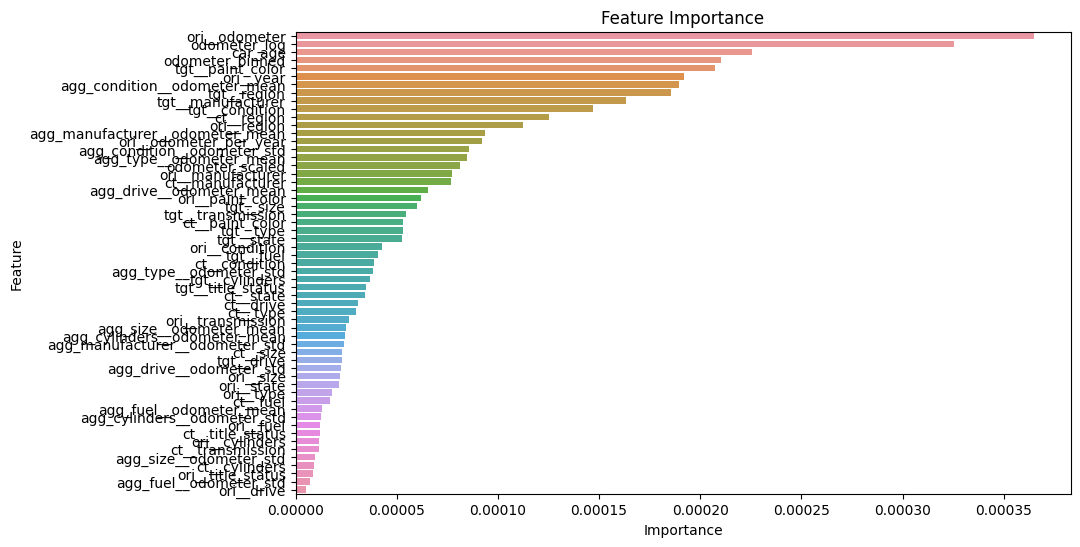

In [ ]:
# Get feature importances
importances = pd.DataFrame({
    'Feature': train_feat_df.columns,
    'Importance': models[0].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='Importance', y='Feature')
plt.title('Feature Importance')

# Select features whose importance is higher than the mean importance
selected_features = importances[importances['Importance'] > importances['Importance'].mean()]['Feature'].tolist()

In [ ]:
# Calculate the 75th percentile of the feature importance
threshold = importances['Importance'].quantile(0.75)

# Select features whose importance is higher than the threshold
selected_features = importances[importances['Importance'] > threshold]['Feature'].tolist()

selected_features

['odometer_scaled',
 'odometer_log',
 'ori__year',
 'car_age',
 'ori__odometer',
 'tgt__condition',
 'ori__odometer_per_year',
 'tgt__manufacturer',
 'tgt__state',
 'agg_condition__odometer_mean',
 'ori__condition_fair',
 'tgt__region',
 'tgt__paint_color',
 'agg_manufacturer__odometer_mean',
 'tgt__drive',
 'ct__condition',
 'ori__region',
 'ct__region',
 'ct__paint_color',
 'tgt__type',
 'ct__state',
 'ori__paint_color_green',
 'tgt__title_status',
 'tgt__transmission',
 'agg_manufacturer__odometer_std',
 'ct__manufacturer',
 'agg_condition__odometer_std',
 'tgt__cylinders',
 'agg_type__odometer_std',
 'tgt__size',
 'tgt__fuel',
 'agg_type__odometer_mean',
 'ct__drive',
 'ct__type',
 'ori__condition_excellent',
 'ori__drive_fwd',
 'agg_drive__odometer_std',
 'agg_cylinders__odometer_std',
 'agg_size__odometer_std',
 'ct__transmission',
 'agg_size__odometer_mean',
 'ori__paint_color_silver',
 'agg_drive__odometer_mean',
 'ori__cylinders',
 'ct__size',
 'ct__title_status',
 'ori__trans

In [ ]:
import xgboost as xgb

In [ ]:
train_feat_df = train_feat_df.fillna(train_feat_df.median())

In [ ]:
def objective_xgb(trial, X, y, cv):

    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': trial.suggest_int('random_state', 1, 1000),
        'n_estimators': trial.suggest_int('n_estimators', 100, 50000),
        'tree_method':'gpu_hist',
        "objective": "reg:squarederror"
    }

    oof_pred = np.zeros_like(y, dtype=np.float32)
    for fold, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        clf = xgb.XGBRegressor(**param)

        clf.fit(x_train, np.log1p(y_train))

        pred_i = np.expm1(clf.predict(x_valid))
        oof_pred[idx_valid] = pred_i

    score = mean_absolute_percentage_error(y, oof_pred)
    return score

def fit_xgb(X, y, cv, verbose=100):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective_xgb(trial, X, y, cv), n_trials=25)
    Best_trial = study.best_trial.params
    Best_trial.update({
        'tree_method':'gpu_hist',
        "objective": "reg:squarederror"
        })

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float32)

    for fold, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        clf = xgb.XGBRegressor(**Best_trial)

        clf.fit(x_train, np.log1p(y_train))

        print("Best params:", Best_trial)

        pred_i = np.expm1(clf.predict(x_valid))
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        score = mean_absolute_percentage_error(y_valid, pred_i)
        print('score for fold {}: {:.4f}'.format(fold, score))

    score = mean_absolute_percentage_error(y, oof_pred)
    print('FINISHED \ whole RMSE: {:.4f}'.format(score))

    return oof_pred, models

oof_xgb, models_xgb = fit_xgb(train_feat_df, train_df["price"], cv)


[I 2023-08-03 03:41:21,331] A new study created in memory with name: no-name-8a1eb072-055a-42ca-b227-86285f957b03
<ipython-input-27-bde914b9b1b4>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-27-bde914b9b1b4>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
[I 2023-08-03 03:42:28,885] Trial 0 finished with value: 0.5417030670660387 and parameters: {'lambda': 0.03148911647956861, 'alpha': 6.351221010640703, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 9, 'min_child_weight': 183, 'random_state': 171, 'n_esti

KeyboardInterrupt: ignored

In [ ]:
def objective_xgb(trial, x_train, x_valid, y_train, y_valid, y, idx_valid):

    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': trial.suggest_int('random_state', 1, 1000),
        'n_estimators': 10000,
        'tree_method':'gpu_hist',
        "objective": "reg:squarederror"
    }


    clf = xgb.XGBRegressor(**param)

    clf.fit(x_train, np.log1p(y_train))

    preds = np.expm1(clf.predict(x_valid))
    score = mean_absolute_percentage_error(y_valid, preds)

    return score


def fit_xgb(X, y, cv, verbose=100):
    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for fold, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(lambda trial: objective_xgb(trial, x_train, x_valid, y_train, y_valid, y, idx_valid), n_trials=25)
        Best_trial = study.best_trial.params
        Best_trial.update({
            'n_estimators': 10000,
            'tree_method':'gpu_hist',
            "objective": "reg:squarederror"
            })

        clf = xgb.XGBRegressor(**Best_trial)

        clf.fit(x_train, np.log1p(y_train))

        print("Best params:", Best_trial)

        pred_i = np.expm1(clf.predict(x_valid))
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        score = mean_absolute_percentage_error(y_valid, pred_i)
        print('score for fold {}: {:.4f}'.format(fold, score))

    score = mean_absolute_percentage_error(y, oof_pred)
    print('FINISHED \ whole RMSE: {:.4f}'.format(score))

    return oof_pred, models

oof_xgb, models_xgb = fit_xgb(train_feat_df, train_df["price"], cv)


[I 2023-08-02 10:45:32,969] A new study created in memory with name: no-name-845d110a-a9b2-4bdf-9b2d-bd6f2ee5a08b
<ipython-input-29-4b1d677000a5>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-29-4b1d677000a5>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
[I 2023-08-02 10:46:10,473] Trial 0 finished with value: 0.5743392523261013 and parameters: {'lambda': 0.03148911647956861, 'alpha': 6.351221010640703, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 9, 'min_child_weight': 183, 'random_state': 171}. Best i

KeyboardInterrupt: ignored

In [ ]:
def objective_cat(trial, x_train, x_valid, y_train, y_valid):
    param = {
        'iterations': trial.suggest_int('iterations', 1000, 5000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000),
        'verbose': 0,
        'eval_metric': 'MAPE',
        'loss_function': 'MAPE'
    }

    clf = cb.CatBoostRegressor(**param)

    clf.fit(x_train, y_train)

    preds = clf.predict(x_valid)
    score = mean_absolute_percentage_error(y_valid, preds)

    return score


def fit_cat(X, y, cv, verbose=100):
    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for fold, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(lambda trial: objective_cat(trial, x_train, x_valid, y_train, y_valid), n_trials=25)
        Best_trial = study.best_trial.params
        Best_trial.update({
            'verbose': 0,
            'eval_metric': 'MAPE',
            'loss_function': 'MAPE'
            })

        clf = cb.CatBoostRegressor(**Best_trial)

        clf.fit(x_train, y_train)

        print("Best params:", Best_trial)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        score = mean_absolute_percentage_error(y_valid, pred_i)
        print('score for fold {}: {:.4f}'.format(fold, score))

    score = mean_absolute_percentage_error(y, oof_pred)
    print('FINISHED \ whole RMSE: {:.4f}'.format(score))

    return oof_pred, models

oof_cat, models_cat = fit_cat(train_feat_df, train_df["price"], cv)

[I 2023-08-02 10:33:36,928] A new study created in memory with name: no-name-ad3eb41b-d09d-47fa-9306-6fc7062a161d
<ipython-input-28-fce597b41d1e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
[I 2023-08-02 10:35:35,432] Trial 0 finished with value: 0.7079213734152787 and parameters: {'iterations': 2498, 'depth': 10, 'learning_rate': 0.22227824312530747, 'l2_leaf_reg': 0.24810409748678125, 'subsample': 0.5780093202212182, 'random_state': 156}. Best is trial 0 with value: 0.7079213734152787.
<ipython-input-28-fce597b41d1e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_lo

KeyboardInterrupt: ignored

In [ ]:
# inference
pred = np.array([model.predict(test_feat_df) for model in models_lgb])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv(f'{model_dir}/submission.csv', index=False, header=False)

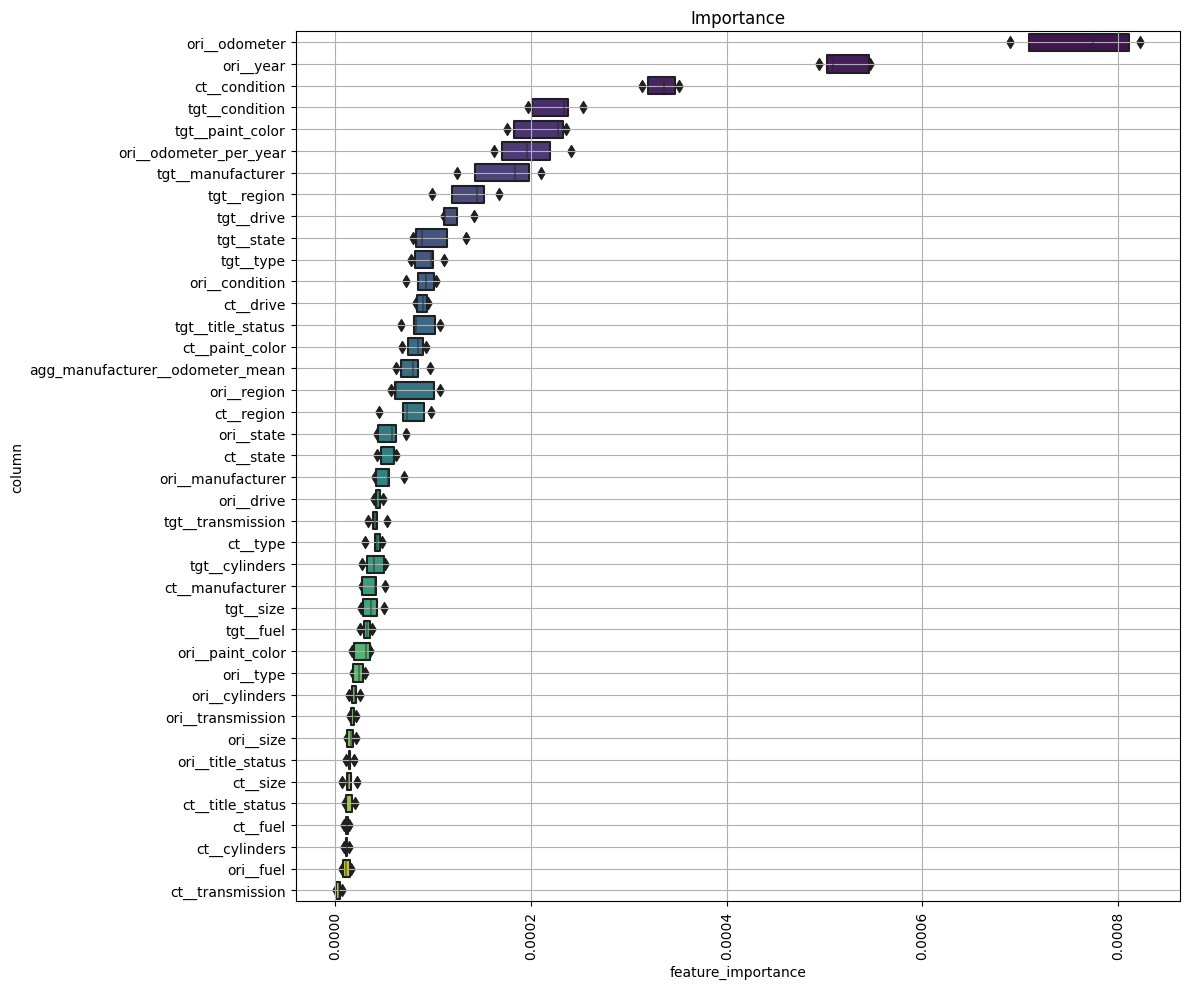

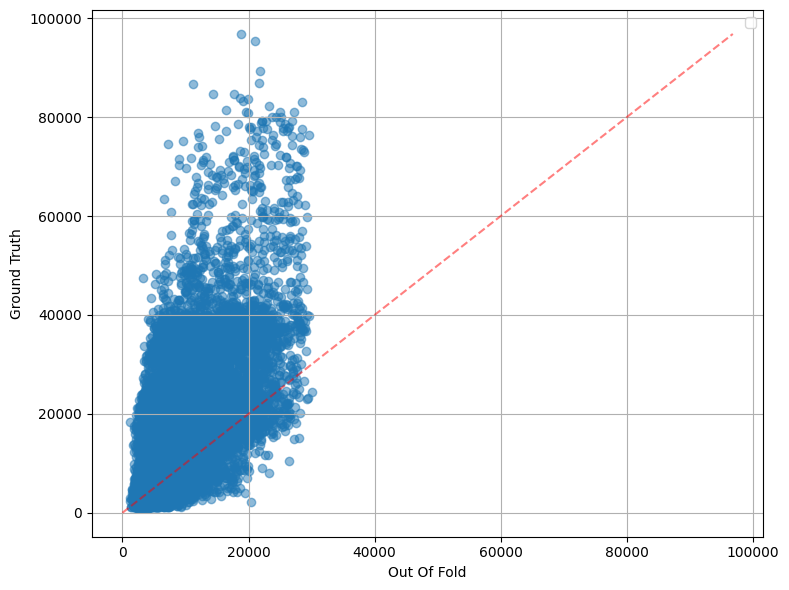

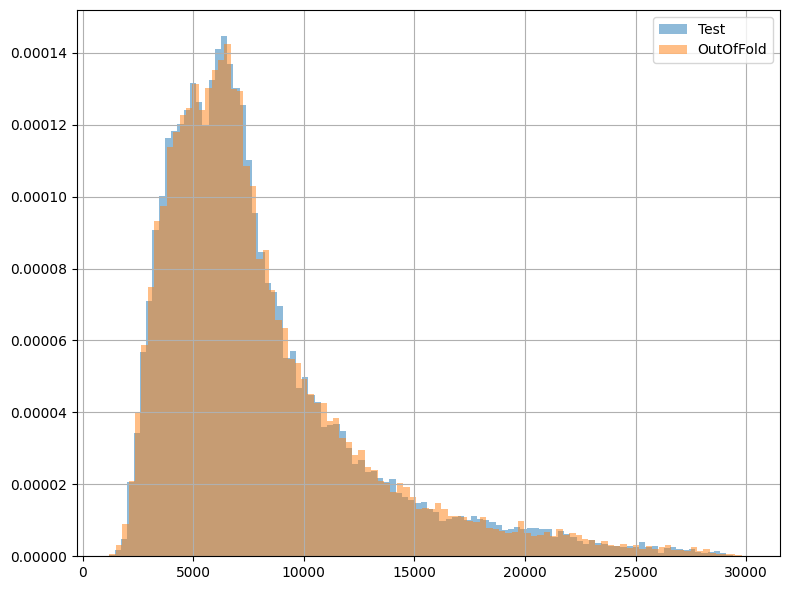

In [ ]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)